## C1조_종합실습1(인도 중고차 가격 예측 프로젝트)

In [1]:
import pandas as pd
import numpy as np
import graphviz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot, add_constant
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
warnings.filterwarnings('ignore')


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'

In [3]:
import warnings
import platform
warnings.filterwarnings('ignore')

## 1. 모델 불러오기

In [37]:
df_raw = pd.read_csv("Car.csv", encoding = 'euc-kr')
df_raw.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN


## 2. 통계 분석

In [38]:
df_raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 736.8+ KB


In [39]:
df_raw.describe()

,Price,Year,Kilometers_Driven,Seats
count,6200.000000,7253.000000,7.253000e+03,7200.000000
mean,14912.514750,2013.365366,5.869906e+04,5.279722
std,17674.318464,3.254421,8.442772e+04,0.811660
min,7.080000,1996.000000,1.710000e+02,0.000000
25%,5365.360000,2011.000000,3.400000e+04,5.000000
50%,8814.520000,2014.000000,5.341600e+04,5.000000
75%,15869.972500,2016.000000,7.300000e+04,5.000000
max,245273.600000,2019.000000,6.500000e+06,10.000000


##### 범주형과 연속형이 섞인 데이터이고 <u>Mileage, Engine, Power</u>는 범주형 데이터이지만 연속형 데이터로 바꿔줄 필요가 있음

In [40]:
df_raw['Mileage'] = df_raw['Mileage'].str.extract(r'(\d+\.?\d*)').astype(float)
df_raw['Engine'] = df_raw['Engine'].str.extract(r'(\d+)').astype(float)  
df_raw['Power'] = df_raw['Power'].str.extract(r'(\d+\.?\d*)').astype(float)


In [41]:
df_raw.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                 175
Seats                  53
New_Price            6247
dtype: int64

## 3. 결측치 제거

##### 데이터의 결측치를 확인해본 결과 종속변수(<u>Price</u>)의 결측치와 독립변수(<u>New_Price,Seats,Engine,Power,Mileage</u>) 순으로 결측치 개수가 측정됨

In [42]:
df = df_raw
df.drop(labels = 'New_Price', axis = 1, inplace = True) 

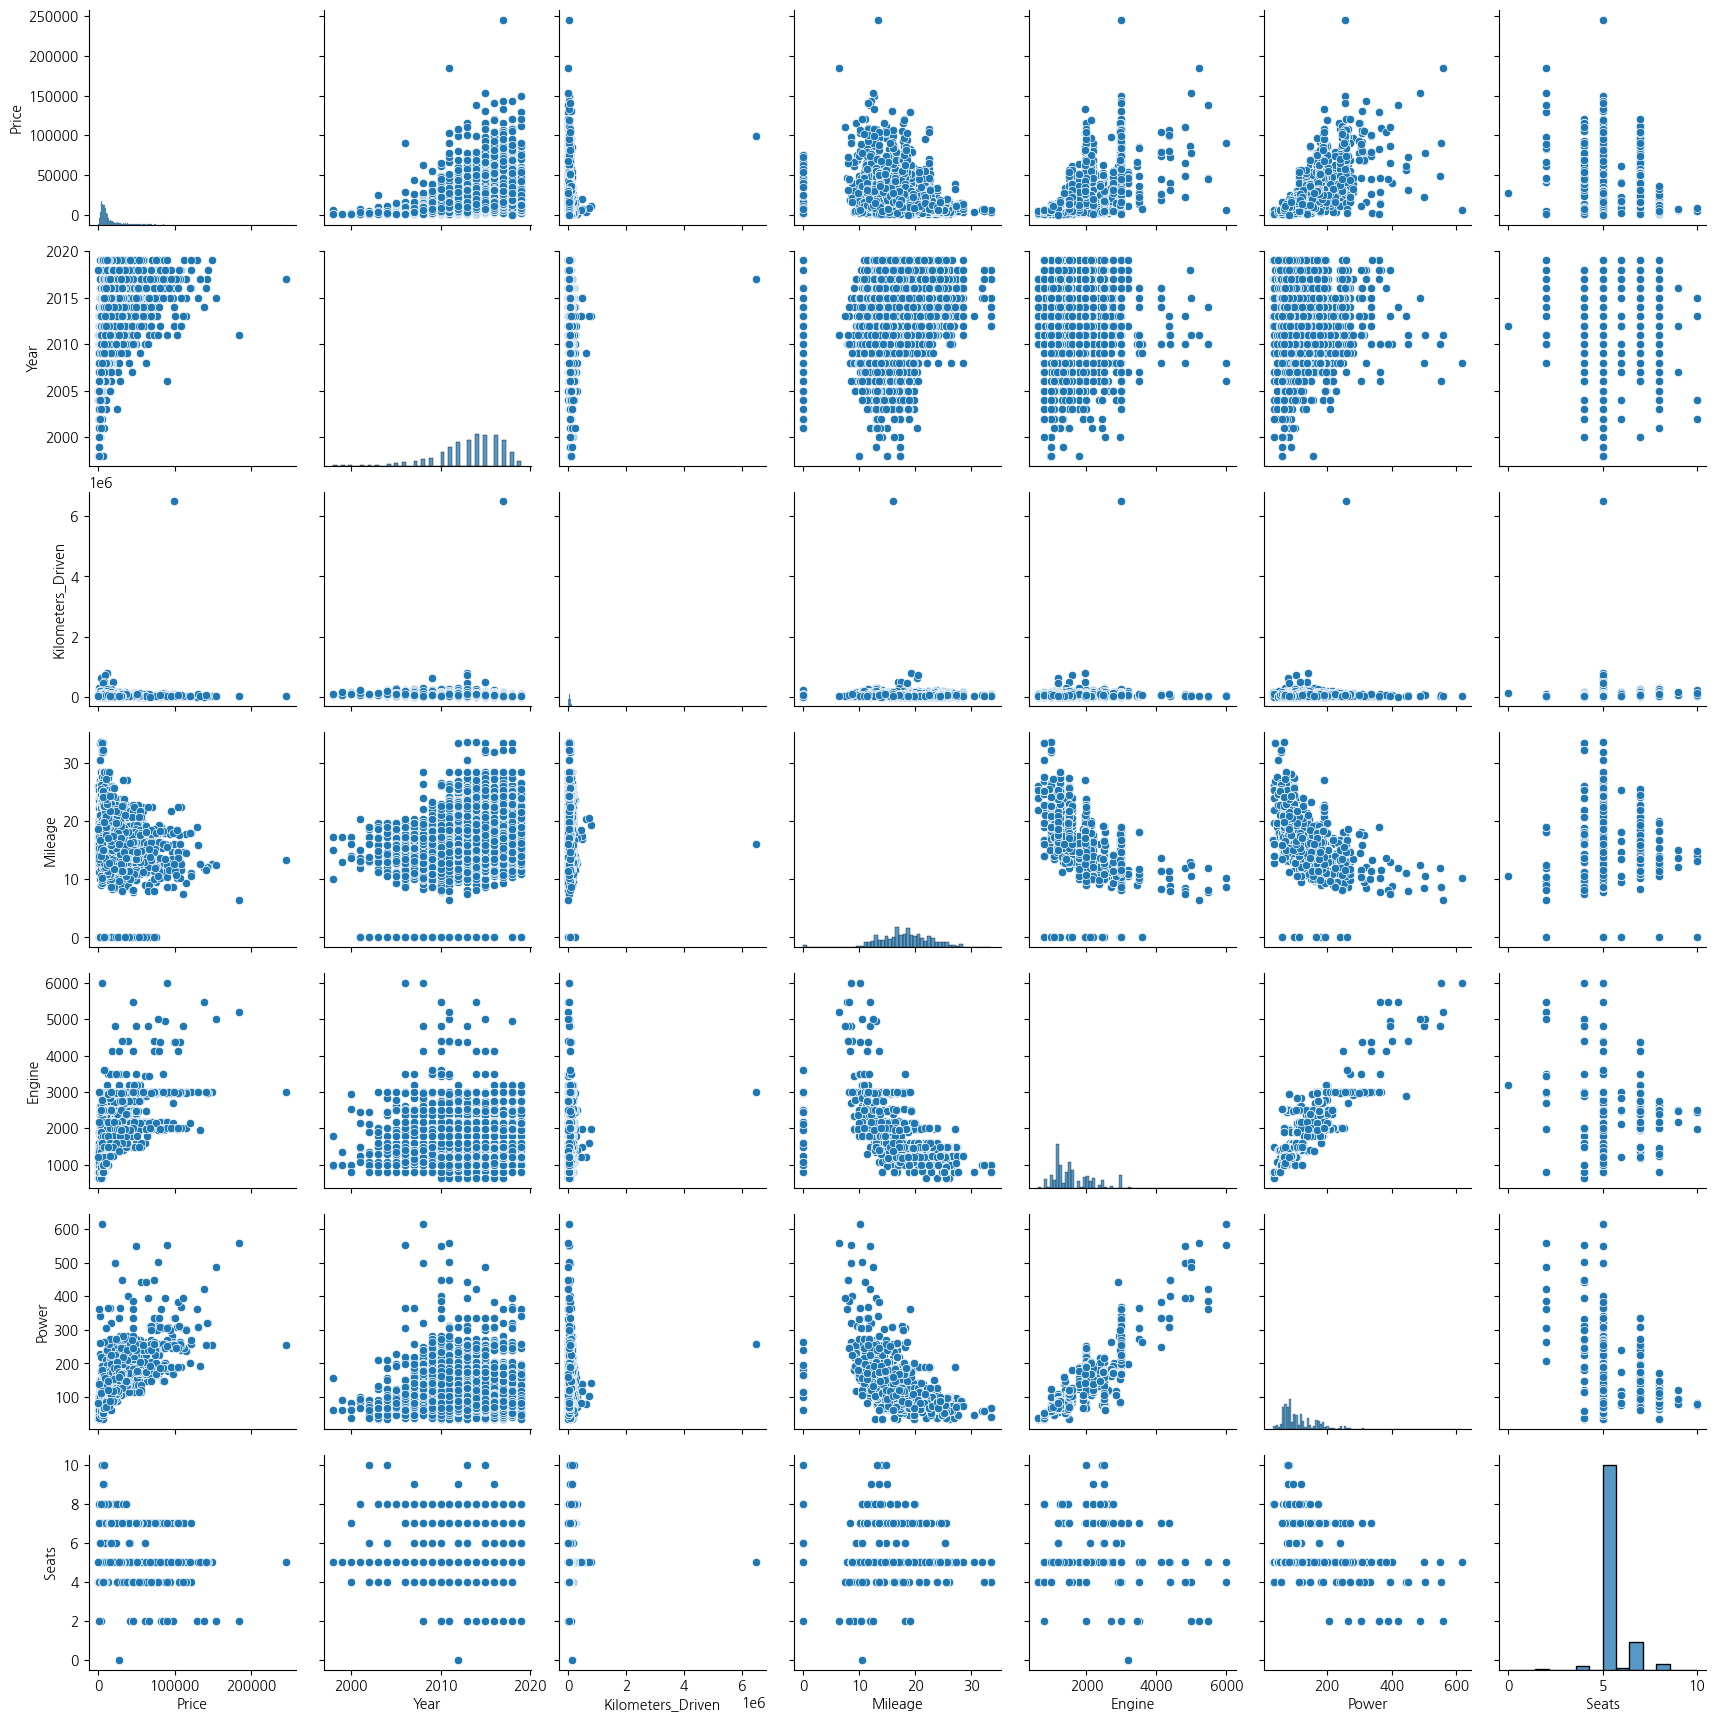

In [51]:
sns.pairplot(df)

In [52]:
df['Mileage'] = np.log1p(df['Mileage'])
df['Power'] = np.log1p(df['Power'])
df['Engine'] = np.log1p(df['Engine'])

##### <u>Engine과 Power</u>의 히스토그램 분포를 봤을 때 왼쪽으로 치우친 경향이 있어 log변환을 하는 것이 맞다고 판단함. 

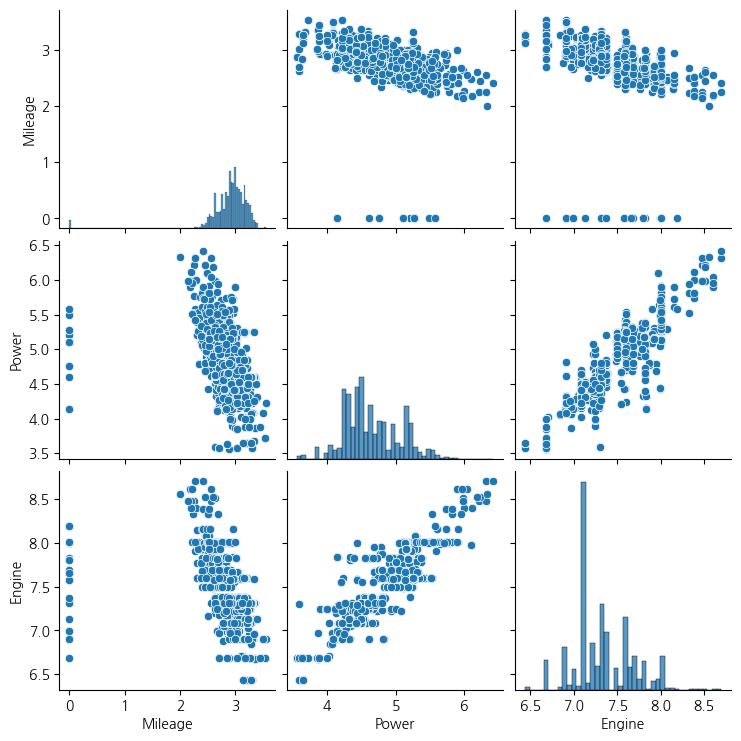

In [55]:
sns.pairplot(df[["Mileage","Power","Engine"]])

In [43]:
df.dropna(subset = ['Price'], inplace = True)

##### New_Price는 결측치가 6247개임으로 열에서 제외하는 것이 맞다고 판단함

In [44]:
df[df['Mileage'].isnull() == True]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
4446,Mahindra E Verito D4,Chennai,19928.48,2016,50000,Electric,Automatic,First,NaN,72.0,41.0,5.0
4904,Toyota Prius 2009-2016 Z4,Mumbai,19545.24,2011,44000,Electric,Automatic,First,NaN,1798.0,73.0,5.0


##### <u>Name과 Fuel_Type</u>이 동일한 행이 있다면 Mileage의 결측치를 채우려 했지만 같지 않아 2개의 Mileage 결측치는 없애는 게 맞다고 판단

In [45]:
df.dropna(subset = ['Mileage'], inplace = True)

In [46]:
df[df['Engine'].isnull() == True]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
194,Honda City 1.5 GXI,Ahmedabad,4522.23,2007,60006,Petrol,Manual,First,0.00,NaN,NaN,NaN
208,Maruti Swift 1.3 VXi,Kolkata,3234.55,2010,42001,Petrol,Manual,First,16.10,NaN,NaN,NaN
733,Maruti Swift 1.3 VXi,Chennai,2682.68,2006,97800,Petrol,Manual,Third,16.10,NaN,NaN,NaN
749,Land Rover Range Rover 3.0 D,Mumbai,40623.44,2008,55001,Diesel,Automatic,Second,0.00,NaN,NaN,NaN
1294,Honda City 1.3 DX,Delhi,4905.47,2009,55005,Petrol,Manual,First,12.80,NaN,NaN,NaN
1327,Maruti Swift 1.3 ZXI,Hyderabad,8891.17,2015,50295,Petrol,Manual,First,16.10,NaN,NaN,NaN
1385,Honda City 1.5 GXI,Pune,2299.44,2004,115000,Petrol,Manual,Second,0.00,NaN,NaN,NaN
1460,Land Rover Range Rover Sport 2005 2012 Sport,Coimbatore,62667.40,2008,69078,Petrol,Manual,First,0.00,NaN,NaN,NaN
2074,Maruti Swift 1.3 LXI,Pune,4828.82,2011,24255,Petrol,Manual,First,16.10,NaN,NaN,NaN
2096,Hyundai Santro LP zipPlus,Coimbatore,2958.61,2004,52146,Petrol,Manual,First,0.00,NaN,NaN,NaN


In [47]:
df[df['Engine'].isnull()].merge(
    df,
    on=['Name', 'Fuel_Type', 'Year'],
    how='inner',
    suffixes=('_null', '_match')
)

,Name,Location_null,Price_null,Year,Kilometers_Driven_null,Fuel_Type,Transmission_null,Owner_Type_null,Mileage_null,Engine_null,...,Seats_null,Location_match,Price_match,Kilometers_Driven_match,Transmission_match,Owner_Type_match,Mileage_match,Engine_match,Power_match,Seats_match
0,Honda City 1.5 GXI,Ahmedabad,4522.23,2007,60006,Petrol,Manual,First,0.00,NaN,...,NaN,Ahmedabad,4522.23,60006,Manual,First,0.00,NaN,NaN,NaN
1,Honda City 1.5 GXI,Ahmedabad,4522.23,2007,60006,Petrol,Manual,First,0.00,NaN,...,NaN,Jaipur,3525.81,75055,Manual,First,12.80,1493.0,100.0,5.0
2,Maruti Swift 1.3 VXi,Kolkata,3234.55,2010,42001,Petrol,Manual,First,16.10,NaN,...,NaN,Kolkata,3234.55,42001,Manual,First,16.10,NaN,NaN,NaN
3,Maruti Swift 1.3 VXi,Chennai,2682.68,2006,97800,Petrol,Manual,Third,16.10,NaN,...,NaN,Chennai,2682.68,97800,Manual,Third,16.10,NaN,NaN,NaN
4,Maruti Swift 1.3 VXi,Chennai,2682.68,2006,97800,Petrol,Manual,Third,16.10,NaN,...,NaN,Jaipur,3602.46,125000,Manual,Fourth & Above,16.10,NaN,NaN,NaN
5,Maruti Swift 1.3 VXi,Chennai,2682.68,2006,97800,Petrol,Manual,Third,16.10,NaN,...,NaN,Delhi,2452.74,63000,Manual,First,16.10,NaN,NaN,NaN
6,Maruti Swift 1.3 VXi,Jaipur,3602.46,2006,125000,Petrol,Manual,Fourth & Above,16.10,NaN,...,NaN,Chennai,2682.68,97800,Manual,Third,16.10,NaN,NaN,NaN
7,Maruti Swift 1.3 VXi,Jaipur,3602.46,2006,125000,Petrol,Manual,Fourth & Above,16.10,NaN,...,NaN,Jaipur,3602.46,125000,Manual,Fourth & Above,16.10,NaN,NaN,NaN
8,Maruti Swift 1.3 VXi,Jaipur,3602.46,2006,125000,Petrol,Manual,Fourth & Above,16.10,NaN,...,NaN,Delhi,2452.74,63000,Manual,First,16.10,NaN,NaN,NaN
9,Maruti Swift 1.3 VXi,Delhi,2452.74,2006,63000,Petrol,Manual,First,16.10,NaN,...,NaN,Chennai,2682.68,97800,Manual,Third,16.10,NaN,NaN,NaN


In [48]:
engine_counts = df.groupby(['Name', 'Fuel_Type', 'Year'])['Engine'].nunique()
valid_groups = engine_counts[engine_counts == 1].index
def fill_unique_engine(row):
    if pd.isna(row['Engine']):  
        group = (row['Name'], row['Fuel_Type'], row['Year'])
        if group in valid_groups:  
            return df.loc[(df['Name'] == row['Name']) &
                              (df['Fuel_Type'] == row['Fuel_Type']) &
                              (df['Year'] == row['Year']), 'Engine'].dropna().iloc[0]
    return row['Engine']  
df['Engine'] = df.apply(fill_unique_engine, axis=1)

##### 정확한 결측치 대체를 위해 <u>Engine</u> 열의 결측치를 <u>Name,Fuel_Type,Year</u> 그룹으로 묶어 같은 그룹일때만 대체하도록 설계함

In [49]:
df[df['Engine'].isnull() == True]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
208,Maruti Swift 1.3 VXi,Kolkata,3234.55,2010,42001,Petrol,Manual,First,16.10,NaN,NaN,NaN
733,Maruti Swift 1.3 VXi,Chennai,2682.68,2006,97800,Petrol,Manual,Third,16.10,NaN,NaN,NaN
749,Land Rover Range Rover 3.0 D,Mumbai,40623.44,2008,55001,Diesel,Automatic,Second,0.00,NaN,NaN,NaN
1294,Honda City 1.3 DX,Delhi,4905.47,2009,55005,Petrol,Manual,First,12.80,NaN,NaN,NaN
1327,Maruti Swift 1.3 ZXI,Hyderabad,8891.17,2015,50295,Petrol,Manual,First,16.10,NaN,NaN,NaN
1385,Honda City 1.5 GXI,Pune,2299.44,2004,115000,Petrol,Manual,Second,0.00,NaN,NaN,NaN
1460,Land Rover Range Rover Sport 2005 2012 Sport,Coimbatore,62667.40,2008,69078,Petrol,Manual,First,0.00,NaN,NaN,NaN
2074,Maruti Swift 1.3 LXI,Pune,4828.82,2011,24255,Petrol,Manual,First,16.10,NaN,NaN,NaN
2096,Hyundai Santro LP zipPlus,Coimbatore,2958.61,2004,52146,Petrol,Manual,First,0.00,NaN,NaN,NaN
2264,Toyota Etios Liva V,Pune,4522.23,2012,24500,Petrol,Manual,Second,18.30,NaN,NaN,NaN


In [50]:
df.isnull().sum()

Name                   0
Location               0
Price                  0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                0
Engine                35
Power                143
Seats                 42
dtype: int64

In [58]:
df.dropna(subset = ['Engine'], inplace = True)

##### <u>Engine</u>의 결측치 값은 평균이나 최빈값 등 통계적인 방법으로 넣는 것보다 결측치가 있는 행을 버리는 것이 맞다고 판단함

In [59]:
df.isnull().sum()

Name                   0
Location               0
Price                  0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                0
Engine                 0
Power                108
Seats                  7
dtype: int64

In [17]:
df[df['Power'].isnull() == True]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
194,Honda City 1.5 GXI,Ahmedabad,4522.23,2007,60006,Petrol,Manual,First,0.0 kmpl,1493 CC,NaN,NaN


In [60]:
Power_counts = df.groupby(['Name'])['Power'].nunique()
valid_groups = Power_counts[Power_counts == 1].index
def fill_unique_engine(row):
    if pd.isna(row['Power']): 
        group = (row['Name'], row['Fuel_Type'], row['Year'])
        if group in valid_groups:  
            return df.loc[(df['Name'] == row['Name']) &
                              (df['Fuel_Type'] == row['Fuel_Type']) &
                              (df['Year'] == row['Year']), 'Power'].dropna().iloc[0]
    return row['Power']  
df['Power'] = df.apply(fill_unique_engine, axis=1)


##### 정확한 결측치 대체를 위해 <u>Power</u> 열의 결측치를 <u>Name,Fuel_Type,Year</u> 그룹으로 묶어 같은 그룹일때만 대체하도록 설계함

In [61]:
df[df['Power'].isnull() == True]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
76,Ford Fiesta 1.4 SXi TDCi,Jaipur,3065.92,2008,111111,Diesel,Manual,First,2.933857,7.244228,NaN,5.0
79,Hyundai Santro Xing XL,Hyderabad,1992.85,2005,87591,Petrol,Manual,First,0.000000,6.991177,NaN,5.0
89,Hyundai Santro Xing XO,Hyderabad,3219.22,2007,73745,Petrol,Manual,First,2.890372,6.991177,NaN,5.0
120,Hyundai Santro Xing XL eRLX Euro III,Mumbai,1303.02,2005,102000,Petrol,Manual,Second,2.890372,6.991177,NaN,5.0
143,Hyundai Santro Xing XO eRLX Euro II,Kochi,2560.04,2008,80759,Petrol,Manual,Third,2.890372,6.991177,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5873,Hyundai Santro Xing XO eRLX Euro II,Pune,1839.55,2006,47200,Petrol,Manual,Second,2.890372,6.991177,NaN,5.0
5893,Maruti Estilo LXI,Chennai,2682.68,2008,51000,Petrol,Manual,Second,3.020425,6.967909,NaN,NaN
5925,Skoda Laura Classic 1.8 TSI,Pune,4368.94,2010,85000,Petrol,Manual,First,2.917771,7.494986,NaN,5.0
5943,Mahindra Jeep MM 540 DP,Chennai,2606.03,2002,75000,Diesel,Manual,First,0.000000,7.655864,NaN,6.0


In [62]:
train_df = df.dropna()
test_df = df[df['Power'].isnull()]
X_train = train_df[['Engine']]  
y_train = train_df['Power']     
model = LinearRegression()
model.fit(X_train, y_train)
X_test = test_df[['Engine']]
y_pred = model.predict(X_test)
df.loc[df['Power'].isnull(), 'Power'] = y_pred
df

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,3.317816,6.906755,4.080246,5.0
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,3.028683,7.367077,4.845761,5.0
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,2.954910,7.090077,4.496471,5.0
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,3.080533,7.130099,4.497139,7.0
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,2.785011,7.585281,4.954418,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7228,Tata Tiago 1.05 Revotorq XT Option,Pune,10822.70,2016,41413,Diesel,Manual,First,3.342155,6.954639,4.248495,5.0
7231,Ford EcoSport 1.5 Petrol Ambiente,Kochi,13474.72,2017,39015,Petrol,Manual,First,2.890372,7.311886,4.806968,5.0
7232,Jeep Compass 1.4 Sport,Mumbai,27838.55,2018,6000,Petrol,Manual,First,2.833213,7.221836,5.081404,5.0
7235,Maruti Vitara Brezza ZDi,Kochi,16203.39,2017,21380,Diesel,Manual,First,3.230804,7.130099,4.494239,5.0


##### <u>Engine과 Power</u>은 산점도 그래프를 통해서 강한 상관관계가 있는 것을 알 수 있음으로 회귀 분석을 통해 <u>Engine</u>의 경향을 토대로 Power을 예측해 결측치를 넣어줌

In [64]:
df.isnull().sum()

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                7
dtype: int64

In [65]:
Seats_counts = df.groupby(['Name'])['Seats'].nunique()
valid_groups = Seats_counts[Seats_counts == 1].index
def fill_unique_Seats(row):
    if pd.isna(row['Seats']):  
        group = (row['Name'], row['Fuel_Type'], row['Year'])
        if group in valid_groups:  
            return df.loc[(df['Name'] == row['Name']) &
                              (df['Fuel_Type'] == row['Fuel_Type']) &
                              (df['Year'] == row['Year']), 'Seats'].dropna().iloc[0]
    return row['Seats']  
df['Seats'] = df.apply(fill_unique_Seats, axis=1)

##### 정확한 결측치 대체를 위해 <u>Seats</u> 열의 결측치를 <u>Name,Fuel_Type,Year</u> 그룹으로 묶어 같은 그룹일때만 대체하도록 설계함

In [66]:
df[df['Seats'].isnull() == True]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
194,Honda City 1.5 GXI,Ahmedabad,4522.23,2007,60006,Petrol,Manual,First,0.000000,7.309212,4.621725,NaN
229,Ford Figo Diesel,Bangalore,5518.66,2015,70436,Diesel,Manual,First,0.000000,7.312553,4.605170,NaN
1917,Honda City 1.5 EXI,Jaipur,2606.03,2005,88000,Petrol,Manual,Second,2.639057,7.309212,4.615121,NaN
2369,Maruti Estilo LXI,Chennai,2299.44,2008,56000,Petrol,Manual,Second,3.020425,6.967909,4.251895,NaN
3800,Ford Endeavour Hurricane LE,Mumbai,10730.72,2012,129000,Diesel,Automatic,First,2.624669,7.990915,5.360407,NaN
3882,Maruti Estilo LXI,Kolkata,3832.40,2010,40000,Petrol,Manual,Second,3.020425,6.967909,4.251895,NaN
5893,Maruti Estilo LXI,Chennai,2682.68,2008,51000,Petrol,Manual,Second,3.020425,6.967909,4.251895,NaN


In [67]:
df.dropna(subset = ['Seats'], inplace = True)

In [68]:
df.isnull().sum()

Name                 0
Location             0
Price                0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
dtype: int64

##### 최종 결측치가 0인 것을 확인하고 결측치 제거를 마무리 함

## 4. EDA

In [76]:
df["Name"].value_counts()

Mahindra XUV500 W8 2WD                            49
Maruti Swift VDI                                  47
Honda City 1.5 S MT                               34
Maruti Swift Dzire VDI                            34
Maruti Swift VDI BSIV                             31
                                                  ..
Tata Zest Quadrajet 1.3                            1
Mitsubishi Pajero 2.8 SFX BSIV Dual Tone           1
Maruti Omni MPI CARGO BSIV                         1
Mercedes-Benz B Class 2012-2015 B200 Sport CDI     1
Hyundai Elite i20 Magna Plus                       1
Name: Name, Length: 1900, dtype: int64

##### 1900개의 모델이 있기 때문에 이 또한 너무 많음으로 임계값을 정해 모델을 만들고 나머지 모델은 other값으로 넣어줌

In [70]:
df['Model'] = df['Name'].apply(lambda x: x.split()[0])
df

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Model
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,3.317816,6.906755,4.080246,5.0,Maruti
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,3.028683,7.367077,4.845761,5.0,Hyundai
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,2.954910,7.090077,4.496471,5.0,Honda
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,3.080533,7.130099,4.497139,7.0,Maruti
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,2.785011,7.585281,4.954418,5.0,Audi
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7228,Tata Tiago 1.05 Revotorq XT Option,Pune,10822.70,2016,41413,Diesel,Manual,First,3.342155,6.954639,4.248495,5.0,Tata
7231,Ford EcoSport 1.5 Petrol Ambiente,Kochi,13474.72,2017,39015,Petrol,Manual,First,2.890372,7.311886,4.806968,5.0,Ford
7232,Jeep Compass 1.4 Sport,Mumbai,27838.55,2018,6000,Petrol,Manual,First,2.833213,7.221836,5.081404,5.0,Jeep
7235,Maruti Vitara Brezza ZDi,Kochi,16203.39,2017,21380,Diesel,Manual,First,3.230804,7.130099,4.494239,5.0,Maruti


##### 자동차 <u>Name</u>을 넣으면 너무 많은 종류가 생기기 때문에 자동차 모델명(<u>Model</u>)만 넣어 분석에 용이하게 바꿔줌 

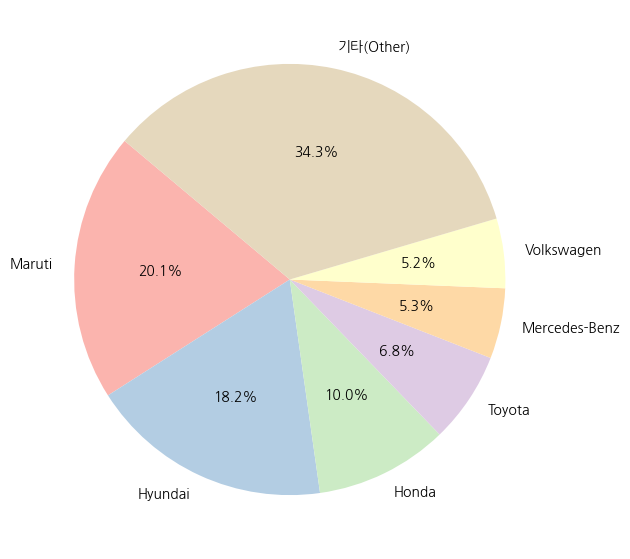

In [71]:
car_counts = df['Model'].value_counts()
total_count = car_counts.sum()
threshold = 0.05 * total_count
filtered_counts = car_counts[car_counts > threshold]
other_count = car_counts[car_counts <= threshold].sum()
if other_count > 0:
    filtered_counts['기타(Other)'] = other_count
cmap = plt.get_cmap('Pastel1')
colors = [cmap(i) for i in range(len(filtered_counts))]
plt.figure(figsize=(7, 7))
plt.pie(filtered_counts, labels=filtered_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.show()

##### 인도차(Maruti), 한국차(Hyundai), 일본차(Toyota,Honda)순으로 아시아 브랜드 차 종류가 높은 비율을 차지함


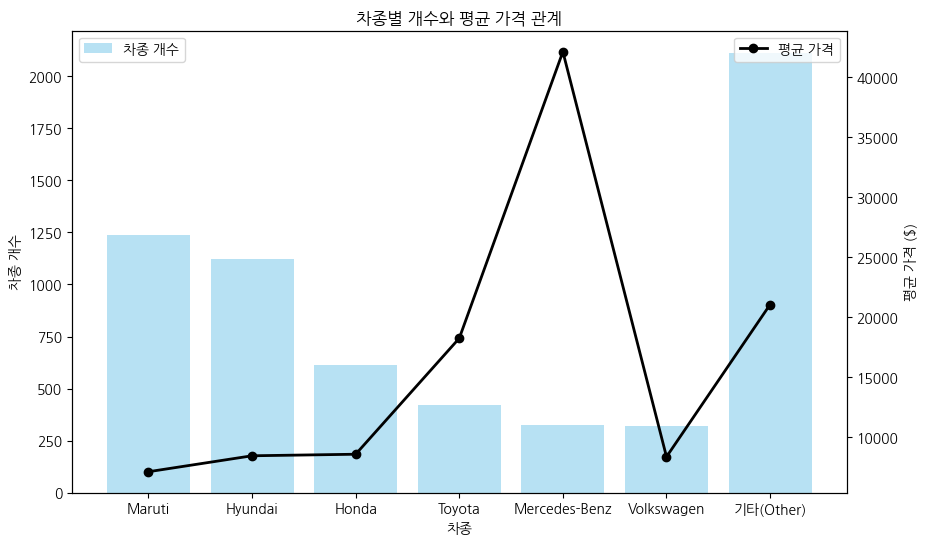

In [72]:
car_counts = df['Model'].value_counts()
total_count = car_counts.sum()
threshold = 0.05 * total_count
filtered_counts = car_counts[car_counts > threshold]
other_count = car_counts[car_counts <= threshold].sum()
if other_count > 0:
    filtered_counts['기타(Other)'] = other_count
average_prices = df.groupby('Model')['Price'].mean()
if other_count > 0:
    other_avg_price = df[df['Model'].isin(car_counts[car_counts <= threshold].index)]['Price'].mean()
    average_prices.loc['기타(Other)'] = other_avg_price
filtered_avg_prices = average_prices.loc[filtered_counts.index]
fig, ax1 = plt.subplots(figsize=(10, 6))

# 바 그래프 (차종별 개수)
color1 = 'skyblue'
ax1.bar(filtered_counts.index, filtered_counts.values, color=color1, alpha=0.6, label='차종 개수')
ax1.set_xlabel('차종')
ax1.set_ylabel('차종 개수', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# 가격 축 (차종별 평균 가격)
ax2 = ax1.twinx()
color2 = 'black'
ax2.plot(filtered_avg_prices.index, filtered_avg_prices.values, color=color2, marker='o', linestyle='-', linewidth=2, label='평균 가격')
ax2.set_ylabel('평균 가격 ($)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# 타이틀 및 레전드 추가
plt.title('차종별 개수와 평균 가격 관계')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

##### 비싼 브랜드일 수록 높은 중고차 가격으로 측정되는 경향이 있음 

In [77]:
# 모델별 개수 계산
car_counts = df['Model'].value_counts()

# 총 개수 및 임계값 계산
total_count = car_counts.sum()
threshold = 0.05 * total_count  # 빈도수가 전체의 5% 이하인 경우 'Other'로 변경

# 임계값 이하 모델을 "Other"로 변경
df['Model'] = df['Model'].apply(lambda x: x if car_counts[x] > threshold else 'Other')
df

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Model
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,3.317816,6.906755,4.080246,5.0,Maruti
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,3.028683,7.367077,4.845761,5.0,Hyundai
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,2.954910,7.090077,4.496471,5.0,Honda
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,3.080533,7.130099,4.497139,7.0,Maruti
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,2.785011,7.585281,4.954418,5.0,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7228,Tata Tiago 1.05 Revotorq XT Option,Pune,10822.70,2016,41413,Diesel,Manual,First,3.342155,6.954639,4.248495,5.0,Other
7231,Ford EcoSport 1.5 Petrol Ambiente,Kochi,13474.72,2017,39015,Petrol,Manual,First,2.890372,7.311886,4.806968,5.0,Other
7232,Jeep Compass 1.4 Sport,Mumbai,27838.55,2018,6000,Petrol,Manual,First,2.833213,7.221836,5.081404,5.0,Other
7235,Maruti Vitara Brezza ZDi,Kochi,16203.39,2017,21380,Diesel,Manual,First,3.230804,7.130099,4.494239,5.0,Maruti


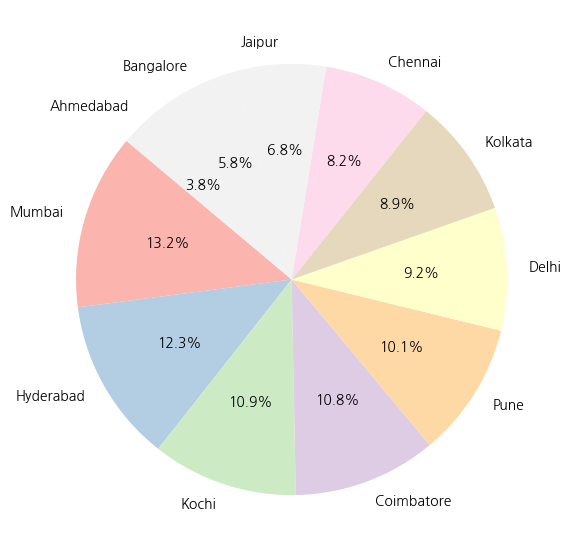

In [78]:
df_location = df["Location"].value_counts()
cmap = plt.get_cmap('Pastel1')
colors = [cmap(i) for i in range(len(df_location))]
plt.figure(figsize=(7, 7))
plt.pie(df_location, labels=df_location.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.show()

부유한 지역 (상)
Mumbai (뭄바이): 인도의 금융 중심지, 부촌 지역인 South Mumbai, Bandra, Juhu 등이 있음.
Delhi (델리): 인도의 수도, Chanakyapuri, Vasant Vihar, Greater Kailash 같은 고급 주거 지역이 많음.
Bangalore (방갈로르): IT 중심지, Whitefield, Indiranagar, Koramangala 같은 부유층 거주 지역 존재.
Pune (푸네): 교육과 IT 허브, Kalyani Nagar, Koregaon Park 같은 부촌 지역 포함.
Hyderabad (하이데라바드): IT 및 스타트업 도시, Banjara Hills, Jubilee Hills 같은 고급 지역이 있음.

중산층 지역 (중)
Chennai (첸나이): 자동차 및 IT 산업 중심지, 일부 부유한 지역과 중산층 지역이 혼합되어 있음.
Kolkata (콜카타): 전통적인 금융 중심지지만 경제 발전이 상대적으로 느림.
Coimbatore (코임바토르): 산업과 교육 중심지, 중산층 거주 지역이 많음.
Kochi (코치): 항구 도시이자 관광 중심지로, 경제적으로 안정적인 중산층이 많음.  

저소득 지역 (하)
Ahmedabad (아메다바드): 제조업 중심이지만 소득 격차가 큼.
Jaipur (자이푸르): 관광 중심이지만 경제적으로 덜 발전한 지역이 많음.



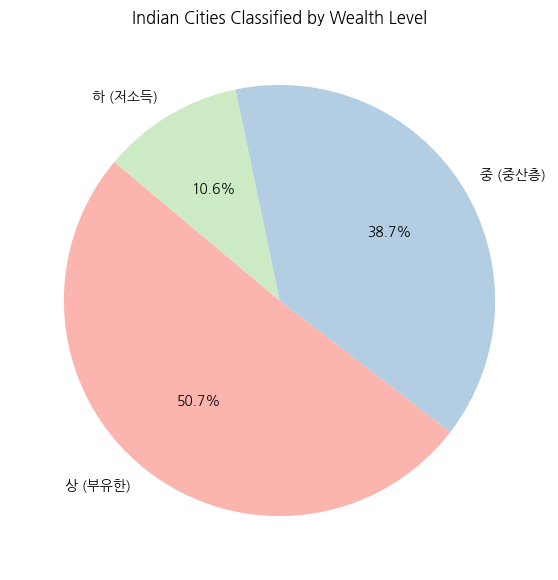

In [79]:
import matplotlib.pyplot as plt
import pandas as pd

# 기존 데이터에서 지역별 개수 추출
df_location = df["Location"].value_counts()

# 📌 지역 그룹화 기준 (상, 중, 하)
rich_areas = ["Mumbai", "Delhi", "Bangalore", "Pune", "Hyderabad"]
middle_areas = ["Chennai", "Kolkata", "Coimbatore", "Kochi"]
poor_areas = ["Ahmedabad", "Jaipur"]

# 📌 부유한(상), 중산층(중), 저소득(하)으로 그룹화
category_counts = {"상 (부유한)": 0, "중 (중산층)": 0, "하 (저소득)": 0}

for location, count in df_location.items():
    if location in rich_areas:
        category_counts["상 (부유한)"] += count
    elif location in middle_areas:
        category_counts["중 (중산층)"] += count
    elif location in poor_areas:
        category_counts["하 (저소득)"] += count

# 📌 데이터프레임으로 변환
df_grouped = pd.Series(category_counts)

# 📌 파이 차트 색상 설정
cmap = plt.get_cmap("Pastel1")
colors = [cmap(i) for i in range(len(df_grouped))]

# 📌 파이 차트 생성
plt.figure(figsize=(7, 7))
plt.pie(df_grouped, labels=df_grouped.index, autopct="%1.1f%%", startangle=140, colors=colors)
plt.title("Indian Cities Classified by Wealth Level")
plt.show()


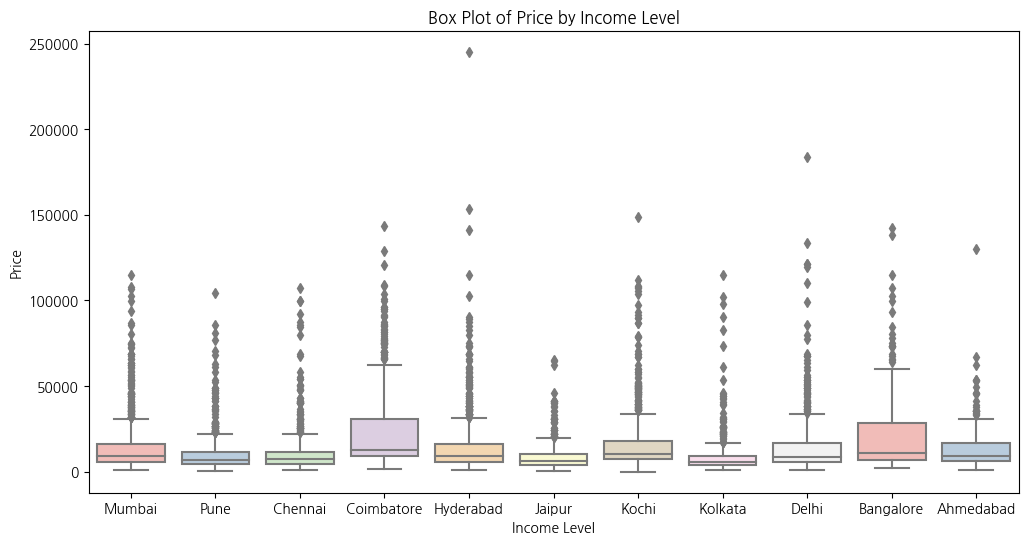

In [80]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Location", y="Price", data=df, palette="Pastel1")
plt.xlabel("Income Level")
plt.ylabel("Price")
plt.title("Box Plot of Price by Income Level")
plt.show()

##### 예를 들어 Jaipur를 하(저소득)으로 넣었고, Hyderabad를 상(부유한)으로 범주형으로 넣은 것을 바꿨을 때 Price 부분이 부유한 지역이 높게 나와 의미있는 변경이라고 판단

In [81]:
rich_areas = ["Mumbai", "Delhi", "Bangalore", "Pune", "Hyderabad"]
middle_areas = ["Chennai", "Kolkata", "Coimbatore", "Kochi"]
poor_areas = ["Ahmedabad", "Jaipur"]

def classify_income(location):
    if location in rich_areas:
        return "상 (부유한)"
    elif location in middle_areas:
        return "중 (중산층)"
    elif location in poor_areas:
        return "하 (저소득)"
    else:
        return "기타"

df["Income_Level"] = df["Location"].apply(classify_income)
df.drop(["Location"],axis=1,inplace=True)

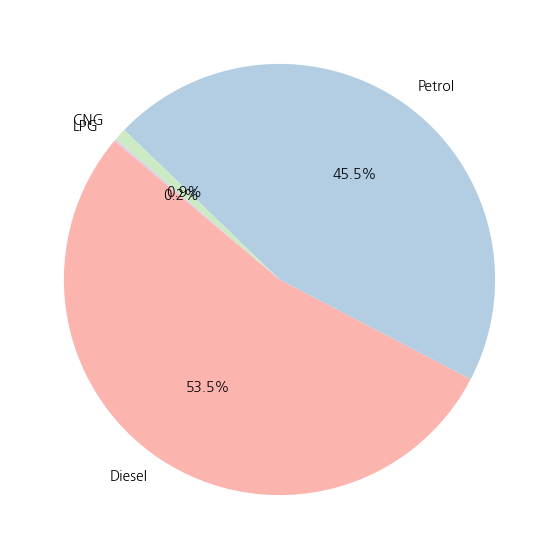

In [82]:
df_location = df["Fuel_Type"].value_counts()
cmap = plt.get_cmap('Pastel1')
colors = [cmap(i) for i in range(len(df_location))]
plt.figure(figsize=(15, 7))
plt.pie(df_location, labels=df_location.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.show()

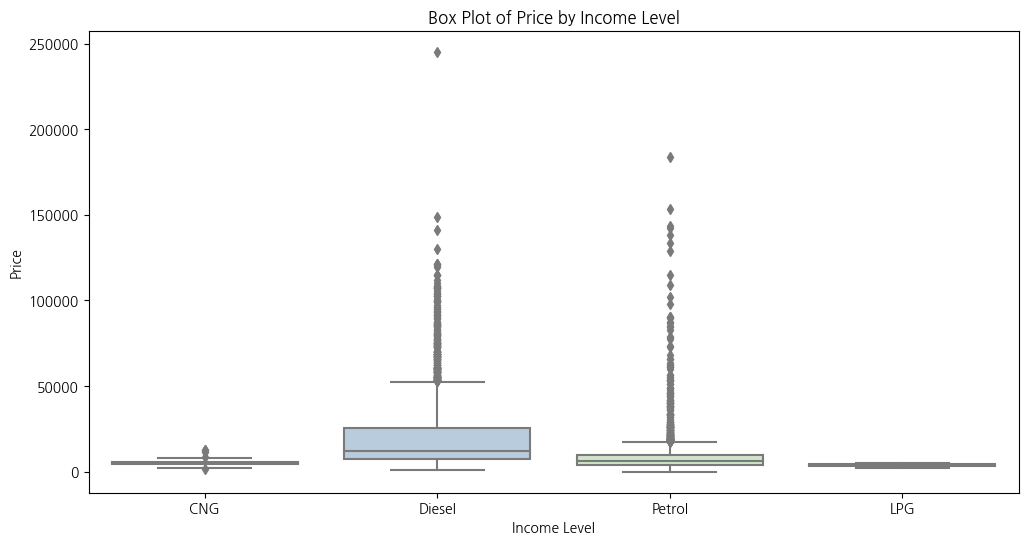

In [45]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Fuel_Type", y="Price", data=df, palette="Pastel1")
plt.xlabel("Income Level")
plt.ylabel("Price")
plt.title("Box Plot of Price by Income Level")
plt.show()

##### Fuel_Type에서는 Price에 대한 별다른 차이가 없는 것으로 보임

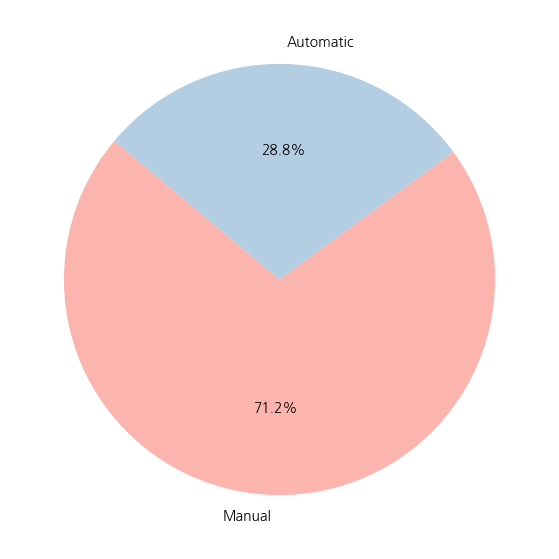

In [84]:
df_location = df["Transmission"].value_counts()
cmap = plt.get_cmap('Pastel1')
colors = [cmap(i) for i in range(len(df_location))]
plt.figure(figsize=(15, 7))
plt.pie(df_location, labels=df_location.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.show()

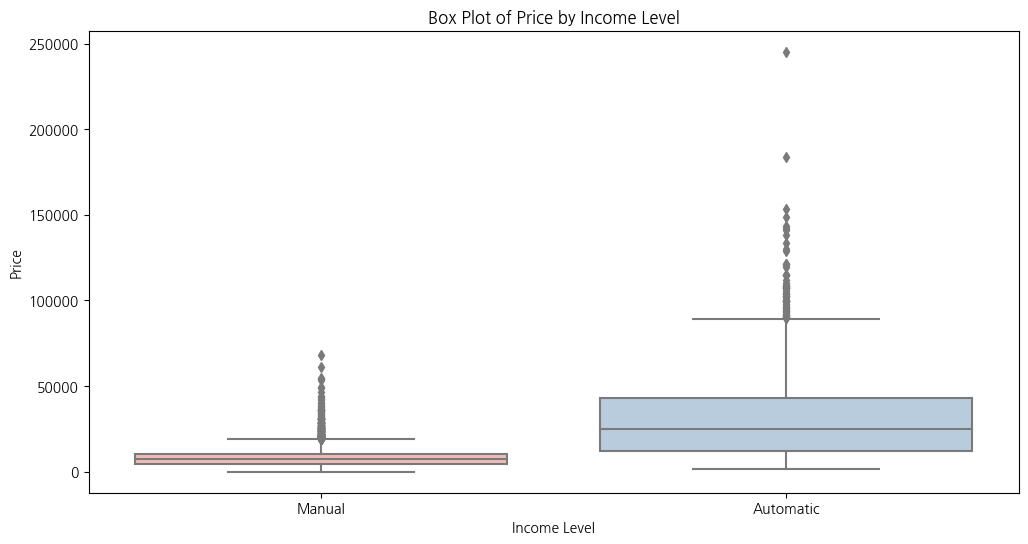

In [85]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Transmission", y="Price", data=df, palette="Pastel1")
plt.xlabel("Income Level")
plt.ylabel("Price")
plt.title("Box Plot of Price by Income Level")
plt.show()

##### Manual은 보통 옛날 차량이고 최신 차는 Automatic이여서 Price가 Automatic이 더 큰다고 판단할 수 있음 

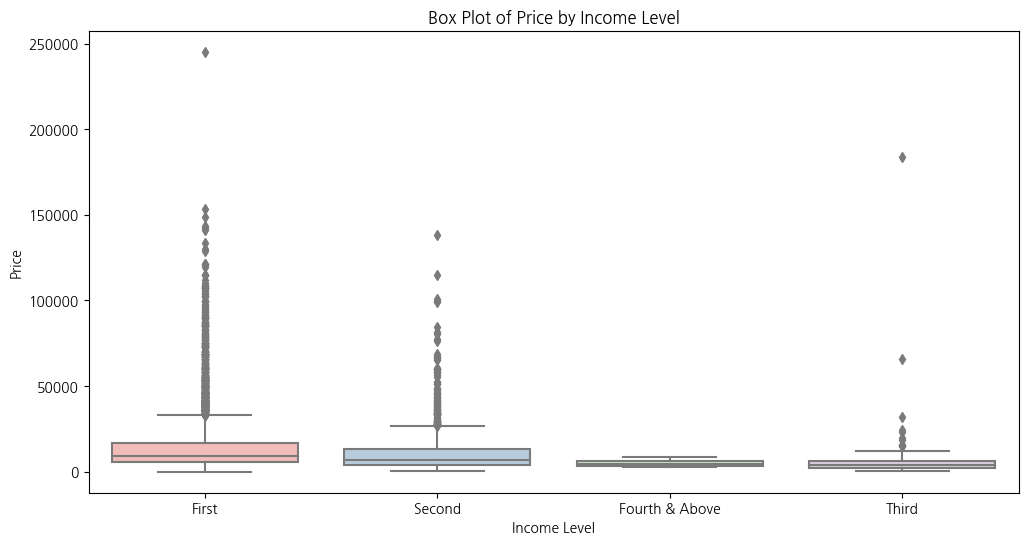

In [48]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Owner_Type", y="Price", data=df, palette="Pastel1")
plt.xlabel("Income Level")
plt.ylabel("Price")
plt.title("Box Plot of Price by Income Level")
plt.show()

##### Owner_Type에서 여러 사람이 소유한 차량일 수록 Price가 낮아지는 경향이 있음

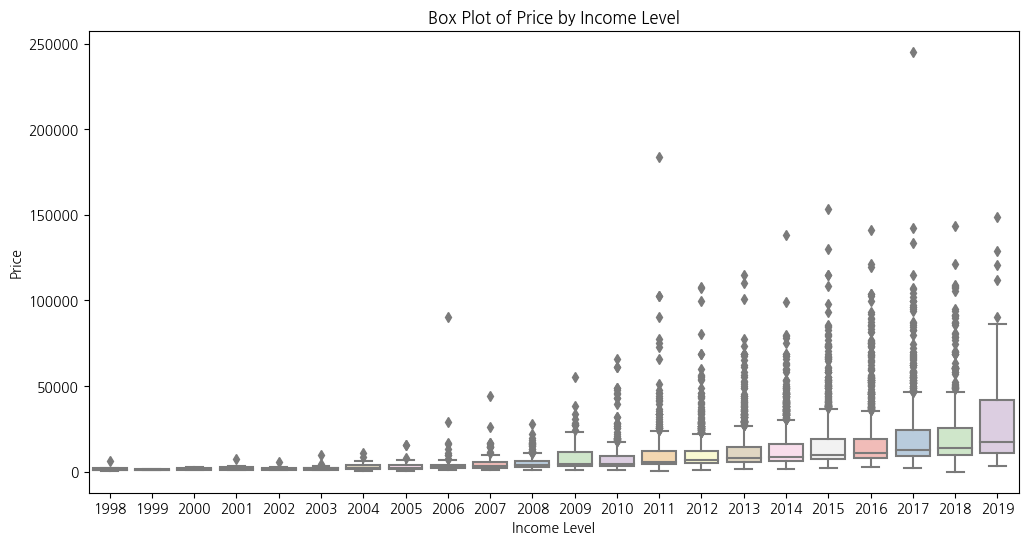

In [89]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Year", y="Price", data=df, palette="Pastel1")
plt.xlabel("Income Level")
plt.ylabel("Price")
plt.title("Box Plot of Price by Income Level")
plt.show()

In [95]:
df[df['Seats'] == 0] #Seats 수가 0개인 데이터 1개 발견

,Name,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Model,Income_Level
3999,Audi A4 3.2 FSI Tiptronic Quattro,27593.28,2012,125000,Petrol,Automatic,First,2.442347,8.070281,5.446406,0.0,Other,상 (부유한)


In [96]:
df = df[df['Seats'] != 0] #Seats수가 0개인 차 삭제(이상치로 판별)

In [97]:
df[df['Mileage'] == 0].count() #Mileage가 0인 값들 발견

Name                 56
Price                56
Year                 56
Kilometers_Driven    56
Fuel_Type            56
Transmission         56
Owner_Type           56
Mileage              56
Engine               56
Power                56
Seats                56
Model                56
Income_Level         56
dtype: int64

In [98]:
# Mileage가 0인 데이터 필터링
mileage_zero = df[df['Mileage'] == 0]

# Mileage가 0이 아닌 데이터 중에서 Name과 Fuel_Type이 동일한 데이터 찾기
valid_mileage = df[(df['Mileage'] > 0) & df[['Model']].apply(tuple, axis=1).isin(mileage_zero[['Model']].apply(tuple, axis=1))]

valid_mileage

,Name,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Model,Income_Level
0,Maruti Wagon R LXI CNG,2682.68,2010,72000,CNG,Manual,First,3.317816,6.906755,4.080246,5.0,Maruti,상 (부유한)
1,Hyundai Creta 1.6 CRDi SX Option,19162.00,2015,41000,Diesel,Manual,First,3.028683,7.367077,4.845761,5.0,Hyundai,상 (부유한)
3,Maruti Ertiga VDI,9197.76,2012,87000,Diesel,Manual,First,3.080533,7.130099,4.497139,7.0,Maruti,중 (중산층)
4,Audi A4 New 2.0 TDI Multitronic,27194.71,2013,40670,Diesel,Automatic,Second,2.785011,7.585281,4.954418,5.0,Other,중 (중산층)
5,Hyundai EON LPG Era Plus Option,3602.46,2012,75000,LPG,Manual,First,3.095578,6.703188,4.028917,5.0,Hyundai,상 (부유한)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7228,Tata Tiago 1.05 Revotorq XT Option,10822.70,2016,41413,Diesel,Manual,First,3.342155,6.954639,4.248495,5.0,Other,상 (부유한)
7231,Ford EcoSport 1.5 Petrol Ambiente,13474.72,2017,39015,Petrol,Manual,First,2.890372,7.311886,4.806968,5.0,Other,중 (중산층)
7232,Jeep Compass 1.4 Sport,27838.55,2018,6000,Petrol,Manual,First,2.833213,7.221836,5.081404,5.0,Other,상 (부유한)
7235,Maruti Vitara Brezza ZDi,16203.39,2017,21380,Diesel,Manual,First,3.230804,7.130099,4.494239,5.0,Maruti,중 (중산층)


In [100]:
df = df[df['Mileage'] != 0]
df

,Name,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Model,Income_Level
0,Maruti Wagon R LXI CNG,2682.68,2010,72000,CNG,Manual,First,3.317816,6.906755,4.080246,5.0,Maruti,상 (부유한)
1,Hyundai Creta 1.6 CRDi SX Option,19162.00,2015,41000,Diesel,Manual,First,3.028683,7.367077,4.845761,5.0,Hyundai,상 (부유한)
2,Honda Jazz V,6898.32,2011,46000,Petrol,Manual,First,2.954910,7.090077,4.496471,5.0,Honda,중 (중산층)
3,Maruti Ertiga VDI,9197.76,2012,87000,Diesel,Manual,First,3.080533,7.130099,4.497139,7.0,Maruti,중 (중산층)
4,Audi A4 New 2.0 TDI Multitronic,27194.71,2013,40670,Diesel,Automatic,Second,2.785011,7.585281,4.954418,5.0,Other,중 (중산층)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7228,Tata Tiago 1.05 Revotorq XT Option,10822.70,2016,41413,Diesel,Manual,First,3.342155,6.954639,4.248495,5.0,Other,상 (부유한)
7231,Ford EcoSport 1.5 Petrol Ambiente,13474.72,2017,39015,Petrol,Manual,First,2.890372,7.311886,4.806968,5.0,Other,중 (중산층)
7232,Jeep Compass 1.4 Sport,27838.55,2018,6000,Petrol,Manual,First,2.833213,7.221836,5.081404,5.0,Other,상 (부유한)
7235,Maruti Vitara Brezza ZDi,16203.39,2017,21380,Diesel,Manual,First,3.230804,7.130099,4.494239,5.0,Maruti,중 (중산층)


<Axes: xlabel='Kilometers_Driven'>

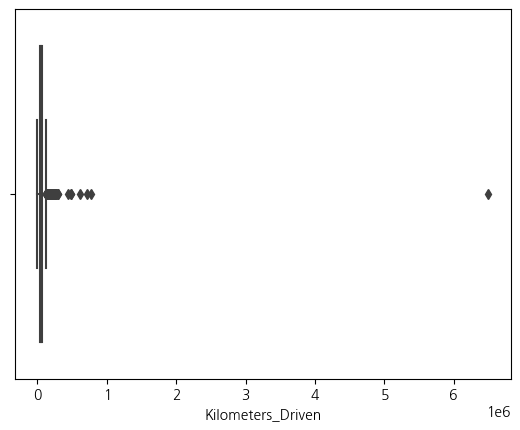

In [60]:
sns.boxplot(x = df['Kilometers_Driven'])

In [61]:
Q1 = df['Kilometers_Driven'].quantile(0.25)
Q3 = df['Kilometers_Driven'].quantile(0.75)
IQR = Q3 - Q1

# IQR 규칙을 사용하여 이상치를 필터링
df = df[~((df['Kilometers_Driven'] < (Q1 - 4 * IQR)) | (df['Kilometers_Driven'] > (Q3 + 4 * IQR)))]

<Axes: xlabel='Kilometers_Driven'>

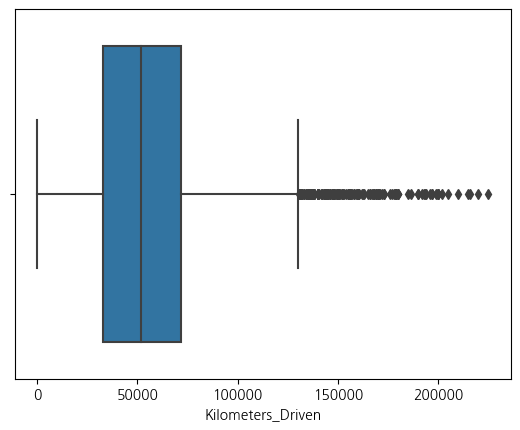

In [62]:
sns.boxplot(x = df['Kilometers_Driven']) #이상치 필터링 후 다시 boxplot 확인

In [63]:
df.isnull().sum()

Name                  0
Price                 0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               0
Engine                0
Power                74
Seats                 0
Model                 0
Income_Level          0
dtype: int64

In [64]:
df_sorted = df.sort_values(by='Price', ascending=False)
df_sorted.head()

,Name,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Model,Income_Level
4079,Land Rover Range Rover 3.0 Diesel LWB Vogue,245273.60,2017,25000,Diesel,Automatic,First,13.33,2993.0,255.0,5.0,Other,상 (부유한)
5781,Lamborghini Gallardo Coupe,183955.20,2011,6500,Petrol,Automatic,Third,6.40,5204.0,560.0,2.0,Other,상 (부유한)
5919,Jaguar F Type 5.0 V8 S,153296.00,2015,8000,Petrol,Automatic,First,12.50,5000.0,488.1,2.0,Other,상 (부유한)
1505,Land Rover Range Rover Sport SE,148804.43,2019,26013,Diesel,Automatic,First,12.65,2993.0,255.0,5.0,Other,중 (중산층)
1974,BMW 7 Series 740Li,143592.36,2018,28060,Petrol,Automatic,First,12.05,2979.0,320.0,5.0,BMW,중 (중산층)


In [65]:
df_sorted = df.sort_values(by='Price', ascending=True)
df_sorted.head()

,Name,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Model,Income_Level
7236,Hyundai Elite i20 Magna Plus,7.08,2018,23955,Petrol,Manual,First,18.6,1197.0,81.86,5.0,Hyundai,중 (중산층)
1713,Tata Nano Lx,674.50,2011,65000,Petrol,Manual,Second,26.0,624.0,35.00,4.0,Other,상 (부유한)
1628,Maruti 800 Std BSIII,689.83,2004,12000,Petrol,Manual,Second,16.1,796.0,37.00,4.0,Maruti,하 (저소득)
2847,Hyundai Getz GLS,689.83,2005,86000,Petrol,Manual,Second,15.3,1341.0,83.00,5.0,Hyundai,상 (부유한)
3138,Maruti Zen LXI,689.83,1998,95150,Petrol,Manual,Third,17.3,993.0,60.00,5.0,Maruti,하 (저소득)


In [66]:
df = df[~((df['Name'] == 'Hyundai Elite i20 Magna Plus') & (df_raw['Price'] == 7.08))]


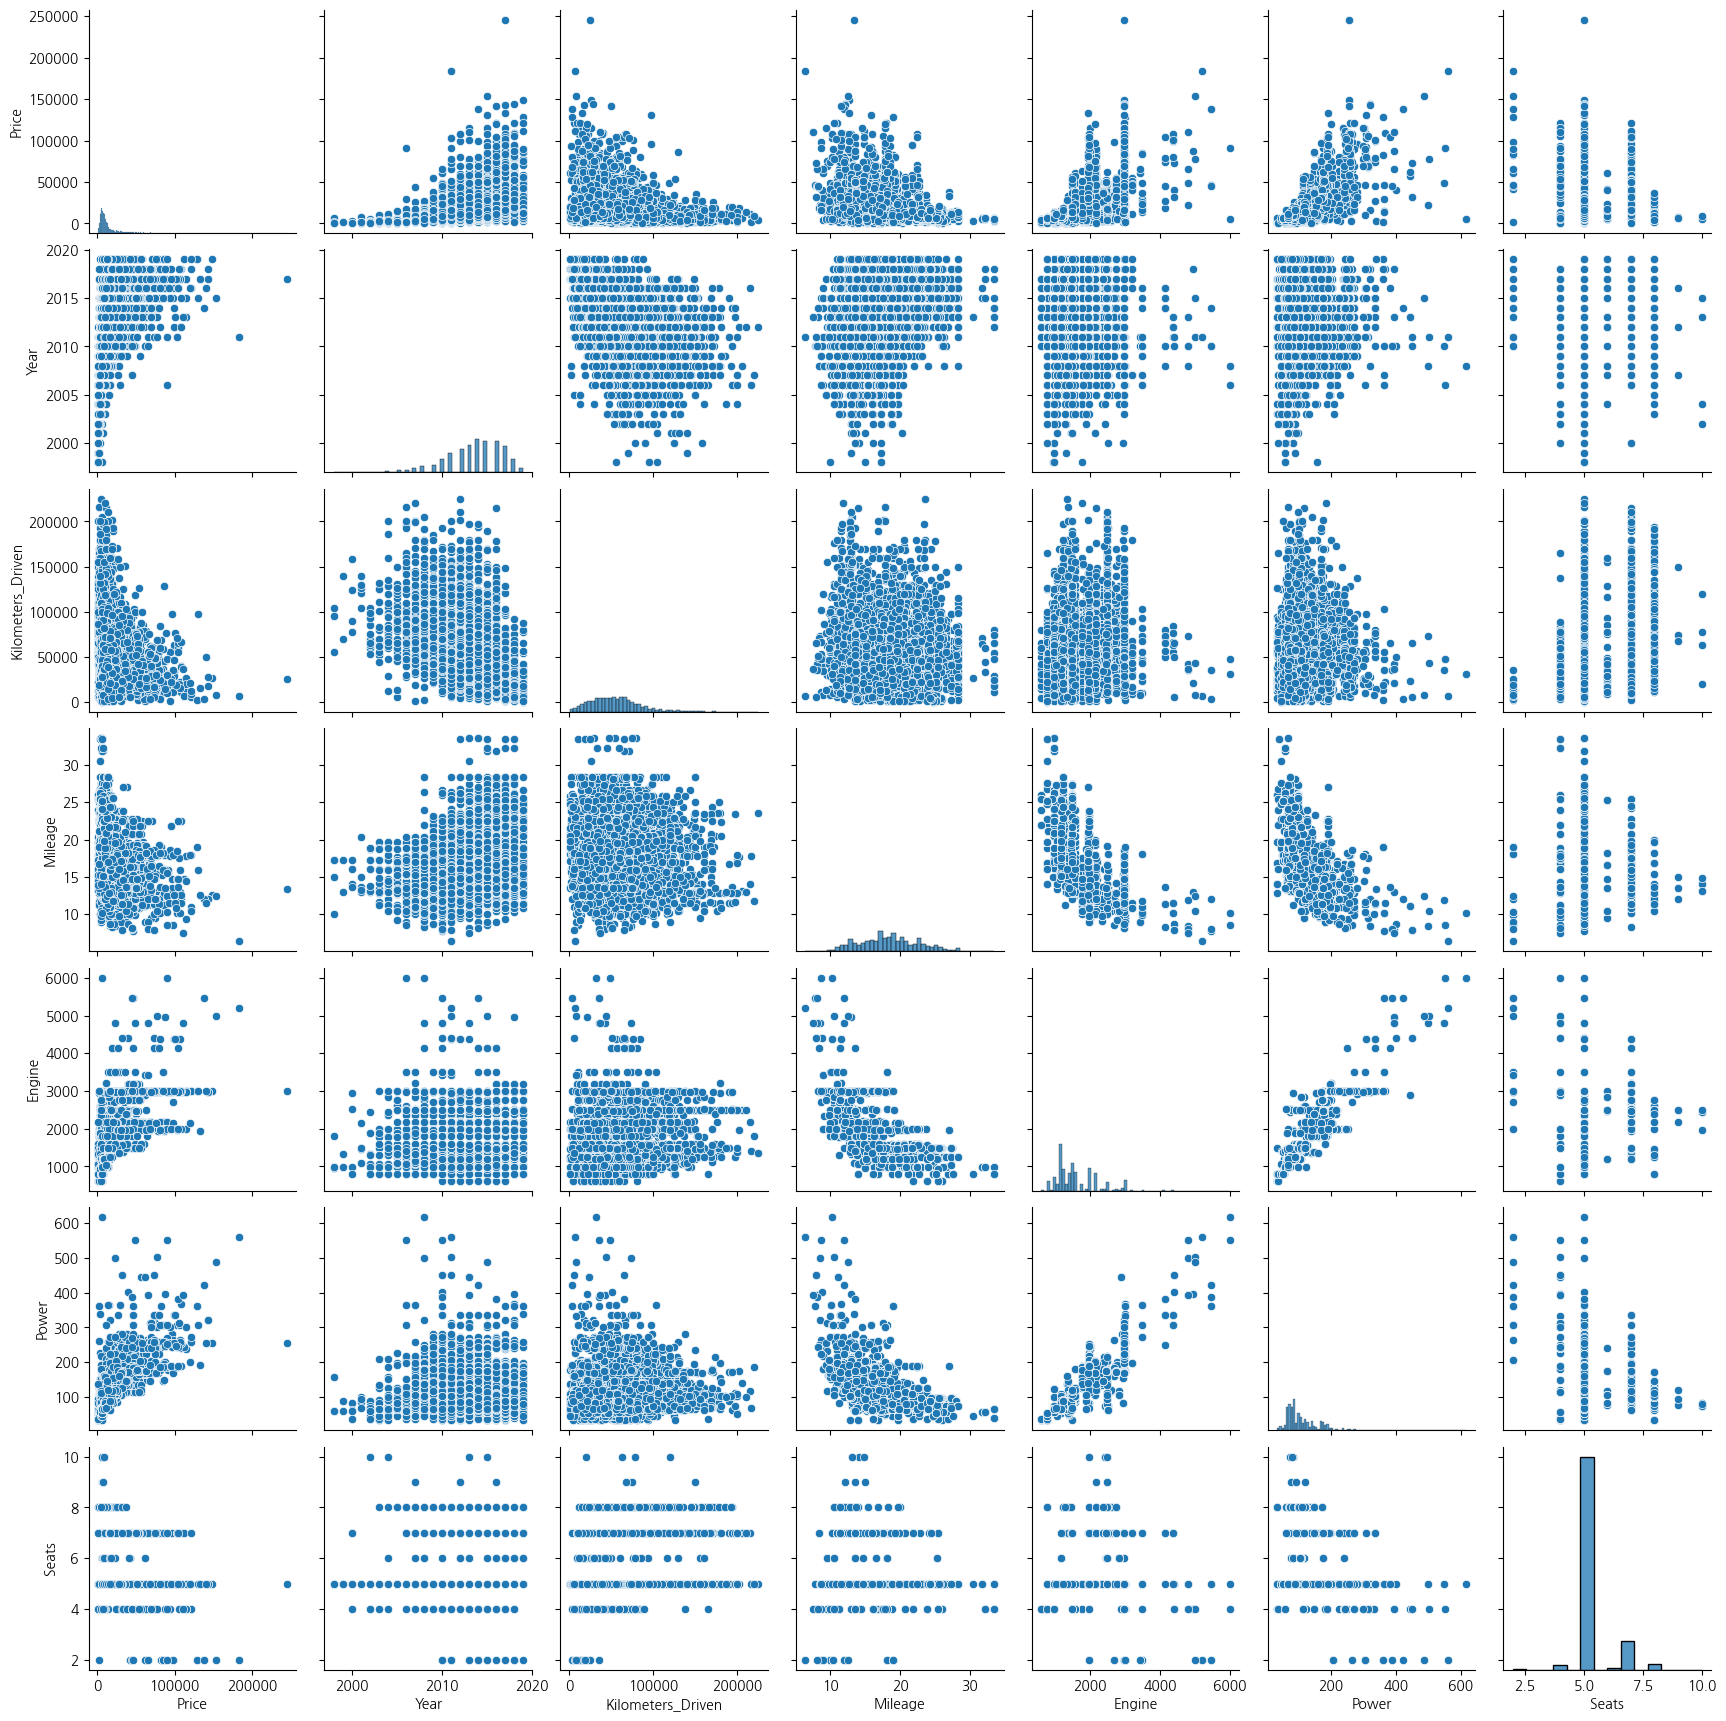

In [67]:
sns.pairplot(df)


In [68]:
df_sorted = df.sort_values(by='Engine', ascending=True)
df_sorted.head()

,Name,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Model,Income_Level
523,Tata Nano Twist XT,1532.96,2014,18000,Petrol,Manual,Second,25.4,624.0,37.50,4.0,Other,하 (저소득)
4965,Tata Nano STD SE,812.47,2012,80000,Petrol,Manual,Second,25.4,624.0,37.50,4.0,Other,하 (저소득)
5468,Tata Nano CX,1931.53,2014,59508,Petrol,Manual,First,25.4,624.0,37.48,4.0,Other,중 (중산층)
4561,Tata Nano Cx BSIV,2575.37,2014,42083,Petrol,Manual,First,25.4,624.0,37.48,4.0,Other,중 (중산층)
5387,Tata Nano Twist XT,3265.20,2015,25811,Petrol,Manual,Second,25.4,624.0,37.50,4.0,Other,중 (중산층)


## 파생변수 추가

In [75]:
current_year = 2024
df['car_age'] = current_year - df['Year']

# 주행 거리 대비 연식(연평균 주행 거리) 계산
df['yearly_mileage'] = df['Mileage'] / df['car_age']

<Axes: xlabel='yearly_mileage'>

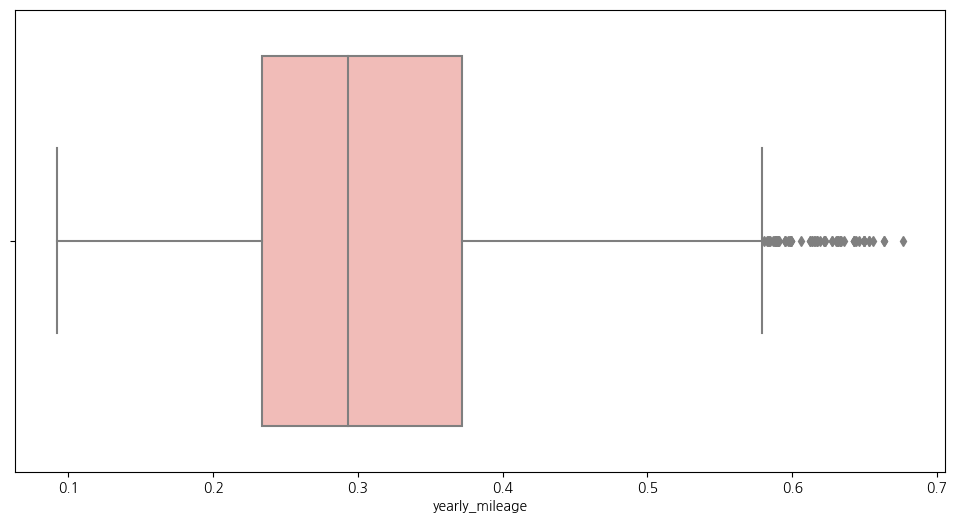

In [76]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="yearly_mileage", data=df, palette="Pastel1")

단기간에 높은 주행거리를 가진 차가 있을 확률이 높음

<Axes: xlabel='Mileage'>

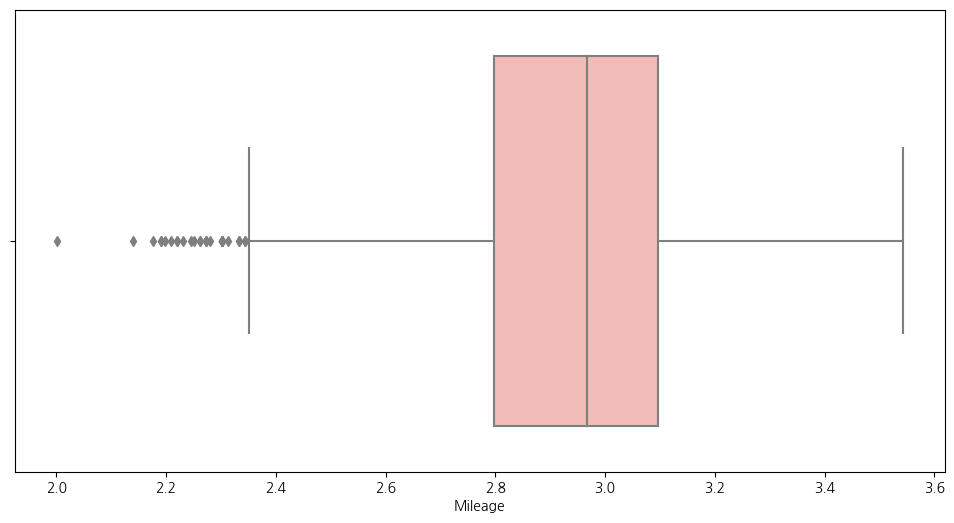

In [78]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Mileage", data=df, palette="Pastel1")

In [79]:
df_encoded = pd.get_dummies(df, columns=['Fuel_Type', 'Transmission', 'Owner_Type', 'Model', 'Income_Level'])
df_encoded.drop(columns=["Name"],inplace=True)
df_encoded.reset_index(inplace=True)
df_encoded

,index,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,car_age,yearly_mileage,...,Model_Hyundai,Model_Mahindra,Model_Maruti,Model_Mercedes-Benz,Model_Other,Model_Toyota,Model_Volkswagen,Income_Level_상 (부유한),Income_Level_중 (중산층),Income_Level_하 (저소득)
0,0,2682.68,2010,72000,3.317816,6.906755,4.080246,5.0,14,0.236987,...,0,0,1,0,0,0,0,1,0,0
1,1,19162.00,2015,41000,3.028683,7.367077,4.845761,5.0,9,0.336520,...,1,0,0,0,0,0,0,1,0,0
2,2,6898.32,2011,46000,2.954910,7.090077,4.496471,5.0,13,0.227301,...,0,0,0,0,0,0,0,0,1,0
3,3,9197.76,2012,87000,3.080533,7.130099,4.497139,7.0,12,0.256711,...,0,0,1,0,0,0,0,0,1,0
4,4,27194.71,2013,40670,2.785011,7.585281,4.954418,5.0,11,0.253183,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6071,7224,8477.27,2016,36000,3.036394,7.089243,4.219508,5.0,8,0.379549,...,0,0,0,0,1,0,0,0,1,0
6072,7228,10822.70,2016,41413,3.342155,6.954639,4.248495,5.0,8,0.417769,...,0,0,0,0,1,0,0,1,0,0
6073,7231,13474.72,2017,39015,2.890372,7.311886,4.806968,5.0,7,0.412910,...,0,0,0,0,0,0,0,0,1,0
6074,7232,27838.55,2018,6000,2.833213,7.221836,5.081404,5.0,6,0.472202,...,0,0,0,0,1,0,0,1,0,0


In [80]:
def z_score_normalization(df):
    scaler = StandardScaler()
    standardized_data = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return standardized_data

z_score_scaled = z_score_normalization(df_encoded.iloc[:,3:10])
df_scaled = pd.concat([z_score_scaled , df_encoded.iloc[:,10:],df_encoded.loc[:,"Price"]],axis=1)
df_scaled

,Kilometers_Driven,Mileage,Engine,Power,Seats,car_age,yearly_mileage,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,...,Model_Mahindra,Model_Maruti,Model_Mercedes-Benz,Model_Other,Model_Toyota,Model_Volkswagen,Income_Level_상 (부유한),Income_Level_중 (중산층),Income_Level_하 (저소득),Price
0,0.502762,1.692256,-1.260205,-1.373794,-0.346320,1.094331,-0.712050,1,0,0,...,0,1,0,0,0,0,1,0,0,2682.68
1,-0.463723,0.391607,0.110742,0.486935,-0.346320,-0.465185,0.281951,0,1,0,...,0,0,0,0,0,0,1,0,0,19162.00
2,-0.307838,0.059742,-0.714229,-0.362080,-0.346320,0.782427,-0.808781,0,0,0,...,0,0,0,0,0,0,0,1,0,6898.32
3,0.970416,0.624849,-0.595035,-0.360454,2.154264,0.470524,-0.515072,0,1,0,...,0,1,0,0,0,0,0,1,0,9197.76
4,-0.474011,-0.704541,0.760605,0.751047,-0.346320,0.158621,-0.550307,0,1,0,...,0,0,0,1,0,0,0,1,0,27194.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6071,-0.619607,0.426294,-0.716712,-1.035291,-0.346320,-0.777089,0.711664,0,0,0,...,0,0,0,1,0,0,0,1,0,8477.27
6072,-0.450846,1.801744,-1.117595,-0.964831,-0.346320,-0.777089,1.093352,0,1,0,...,0,0,0,1,0,0,1,0,0,10822.70
6073,-0.525609,-0.230582,-0.053629,0.392641,-0.346320,-1.088992,1.044826,0,0,0,...,0,0,0,0,0,0,0,1,0,13474.72
6074,-1.554915,-0.487706,-0.321820,1.059712,-0.346320,-1.400895,1.636951,0,0,0,...,0,0,0,1,0,0,1,0,0,27838.55


In [81]:
df

,Name,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Model,Income_Level,car_age,yearly_mileage
0,Maruti Wagon R LXI CNG,2682.68,2010,72000,CNG,Manual,First,3.317816,6.906755,4.080246,5.0,Maruti,상 (부유한),14,0.236987
1,Hyundai Creta 1.6 CRDi SX Option,19162.00,2015,41000,Diesel,Manual,First,3.028683,7.367077,4.845761,5.0,Hyundai,상 (부유한),9,0.336520
2,Honda Jazz V,6898.32,2011,46000,Petrol,Manual,First,2.954910,7.090077,4.496471,5.0,Honda,중 (중산층),13,0.227301
3,Maruti Ertiga VDI,9197.76,2012,87000,Diesel,Manual,First,3.080533,7.130099,4.497139,7.0,Maruti,중 (중산층),12,0.256711
4,Audi A4 New 2.0 TDI Multitronic,27194.71,2013,40670,Diesel,Automatic,Second,2.785011,7.585281,4.954418,5.0,Other,중 (중산층),11,0.253183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7224,Datsun GO T Petrol,8477.27,2016,36000,Petrol,Manual,First,3.036394,7.089243,4.219508,5.0,Other,중 (중산층),8,0.379549
7228,Tata Tiago 1.05 Revotorq XT Option,10822.70,2016,41413,Diesel,Manual,First,3.342155,6.954639,4.248495,5.0,Other,상 (부유한),8,0.417769
7231,Ford EcoSport 1.5 Petrol Ambiente,13474.72,2017,39015,Petrol,Manual,First,2.890372,7.311886,4.806968,5.0,Ford,중 (중산층),7,0.412910
7232,Jeep Compass 1.4 Sport,27838.55,2018,6000,Petrol,Manual,First,2.833213,7.221836,5.081404,5.0,Other,상 (부유한),6,0.472202


In [82]:
def z_score_normalization(df):
    scaler = StandardScaler()
    standardized_data = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return standardized_data

z_score_scaled = z_score_normalization(df.select_dtypes('number')).reset_index()
df_scaled_ols=pd.concat([z_score_scaled, df.select_dtypes('object').reset_index()],axis=1).drop(columns=["index",'Name'],axis=1)
df_scaled_ols

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,car_age,yearly_mileage,Fuel_Type,Transmission,Owner_Type,Model,Income_Level
0,-0.694324,-1.094331,0.502762,1.692256,-1.260205,-1.373794,-0.346320,1.094331,-0.712050,CNG,Manual,First,Maruti,상 (부유한)
1,0.240315,0.465185,-0.463723,0.391607,0.110742,0.486935,-0.346320,-0.465185,0.281951,Diesel,Manual,First,Hyundai,상 (부유한)
2,-0.455230,-0.782427,-0.307838,0.059742,-0.714229,-0.362080,-0.346320,0.782427,-0.808781,Petrol,Manual,First,Honda,중 (중산층)
3,-0.324815,-0.470524,0.970416,0.624849,-0.595035,-0.360454,2.154264,0.470524,-0.515072,Diesel,Manual,First,Maruti,중 (중산층)
4,0.695897,-0.158621,-0.474011,-0.704541,0.760605,0.751047,-0.346320,0.158621,-0.550307,Diesel,Automatic,Second,Other,중 (중산층)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6071,-0.365679,0.777089,-0.619607,0.426294,-0.716712,-1.035291,-0.346320,-0.777089,0.711664,Petrol,Manual,First,Other,중 (중산층)
6072,-0.232656,0.777089,-0.450846,1.801744,-1.117595,-0.964831,-0.346320,-0.777089,1.093352,Diesel,Manual,First,Other,상 (부유한)
6073,-0.082244,1.088992,-0.525609,-0.230582,-0.053629,0.392641,-0.346320,-1.088992,1.044826,Petrol,Manual,First,Ford,중 (중산층)
6074,0.732413,1.400895,-1.554915,-0.487706,-0.321820,1.059712,-0.346320,-1.400895,1.636951,Petrol,Manual,First,Other,상 (부유한)


In [83]:
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# VIF 결과 출력
vif_result = calculate_vif(df_scaled.iloc[:,0:7])
vif_result

,Feature,VIF
0,Kilometers_Driven,1.601381
1,Mileage,2.520756
2,Engine,8.190095
3,Power,6.759607
4,Seats,1.660863
5,car_age,7.226621
6,yearly_mileage,7.868518


vif가 10이하임으로 모두 다중공산성을 만족한다고 볼 수 있다

In [84]:
import statsmodels.formula.api as smf

# 다중 선형 회귀 모델 수식 (범주형 변수 포함)
formula = "Price ~ Kilometers_Driven + Mileage + Engine + Power + Seats + car_age + yearly_mileage + \
           C(Fuel_Type) + C(Transmission) + C(Owner_Type) + C(Model) + C(Income_Level)"

# OLS 회귀 분석 수행
reg_model = smf.ols(formula=formula, data=df_scaled_ols)
reg_result = reg_model.fit()

# 회귀 분석 결과 출력
print(reg_result.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     447.6
Date:                Thu, 20 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:05:45   Log-Likelihood:                -5440.0
No. Observations:                6076   AIC:                         1.093e+04
Df Residuals:                    6050   BIC:                         1.111e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

## 파생변수 추가

# 랜덤포레스트

In [149]:

df_scaled_y = df_scaled["Price"]
df_scaled_x = df_scaled.drop("Price", axis = 1, inplace = False)
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_scaled_x, df_scaled_y, test_size = 0.3, random_state = 1234) 

In [150]:
rf_uncustomized = RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on training set: 0.977
Score on test set: 0.867


In [151]:
rf_uncustomized.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}

In [152]:
train_score = []; test_score = []
# n_estimatos: 트리 수 변경: 1~100
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators = v_n_estimators, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

In [154]:
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.970,0.851
1,20,0.975,0.858
2,30,0.976,0.861
3,40,0.976,0.864
4,50,0.976,0.863
5,60,0.977,0.862
6,70,0.977,0.863
7,80,0.977,0.865
8,90,0.977,0.866
9,100,0.977,0.867


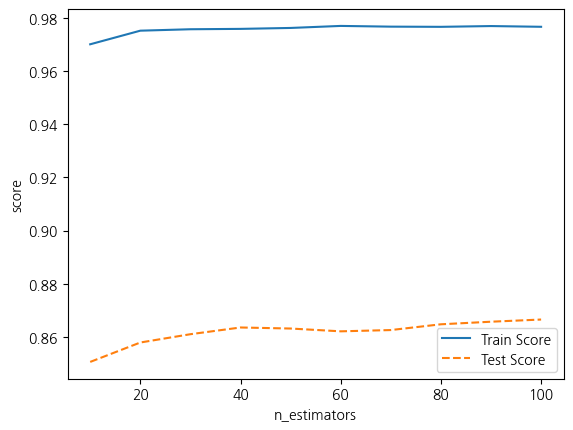

In [155]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

In [156]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수 
para_leaf = [n_leaf for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor(random_state=1234, n_estimators = 100,
                                min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.977,0.867
1,2,0.954,0.873
2,3,0.937,0.867
3,4,0.924,0.864
4,5,0.913,0.862
5,6,0.903,0.860
6,7,0.895,0.857
7,8,0.889,0.856
8,9,0.884,0.853
9,10,0.879,0.849


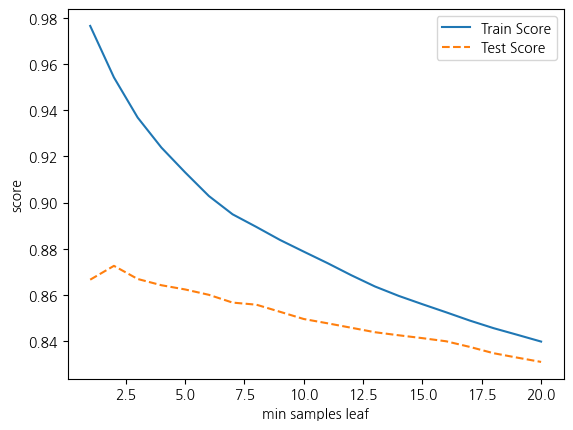

In [158]:
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

In [159]:
train_score = []; test_score = []
# min_samples_split: 분할하기 위한 노드의 최소 자료 수 
para_split = [n_split * 2for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(random_state=1234, n_estimators = 100, min_samples_leaf = 15,
                               min_samples_split = v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.856,0.841
1,6,0.856,0.841
2,8,0.856,0.841
3,10,0.856,0.841
4,12,0.856,0.841
5,14,0.856,0.841
6,16,0.856,0.841
7,18,0.856,0.841
8,20,0.856,0.841
9,22,0.856,0.841


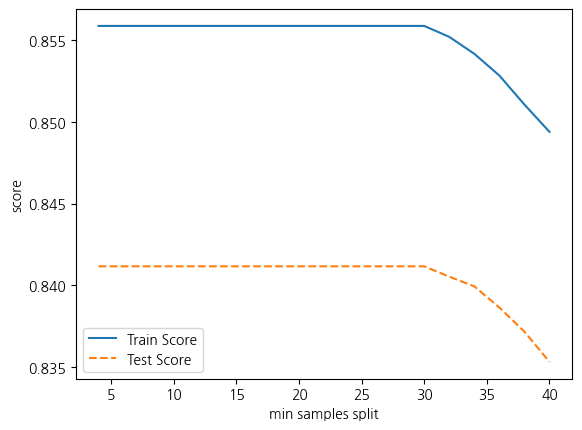

In [161]:
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

In [162]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(random_state=1234, n_estimators = 100,
                               min_samples_leaf = 6, min_samples_split = 25,
                               max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.501,0.458
1,2,0.672,0.649
2,3,0.768,0.749
3,4,0.818,0.802
4,5,0.851,0.829
5,6,0.868,0.841
6,7,0.876,0.847
7,8,0.881,0.851
8,9,0.883,0.852
9,10,0.884,0.853


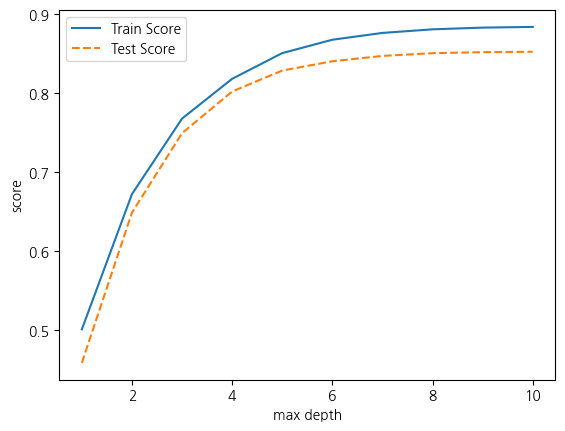

In [163]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()

In [164]:
rf_final = RandomForestRegressor(random_state=1234, n_estimators = 100, min_samples_leaf = 6,
                                 min_samples_split = 14, max_depth = 6)
rf_final.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

Score on training set: 0.874
Score on test set: 0.843


In [165]:
test_pred = rf_final.predict(df_test_x)
print('test data의 실제값 : \n', df_test_y[:10])
print('test data의 예측값 : \n', test_pred[:10])

test data의 실제값 : 
 3838     5196.73
1391    12646.92
4458    19545.24
1281     6898.32
1386    38324.00
2302    15881.47
3879     8277.98
2622     7649.47
1524    19315.30
330      4292.29
Name: Price, dtype: float64
test data의 예측값 : 
 [ 4968.88618123 10398.02476883 17710.00227794  6073.91770731
 35519.74758028 16432.92233317 11339.47802973  5981.94965394
 18084.7651293   5068.32953285]


In [166]:
rf_final.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'min_samples_split': 14,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}

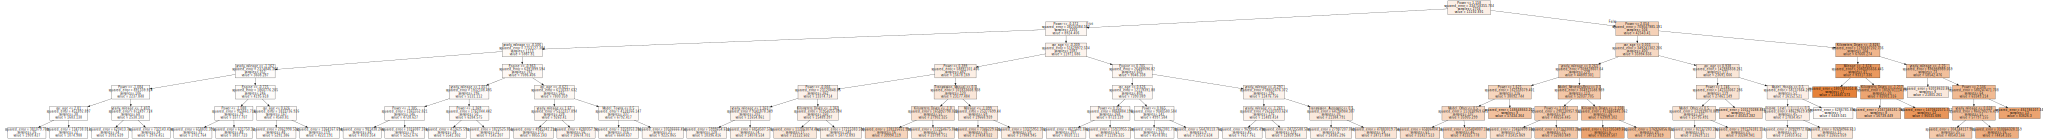

In [167]:
# 변수명 저장
v_feature_name = df_train_x.columns
# 0번 트리
export_graphviz(rf_final.estimators_[0], out_file="rfr_final_0.dot", feature_names = v_feature_name , 
                impurity = True, filled = True)
# tree_final_0.dot 그리기
with open("rfr_final_0.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

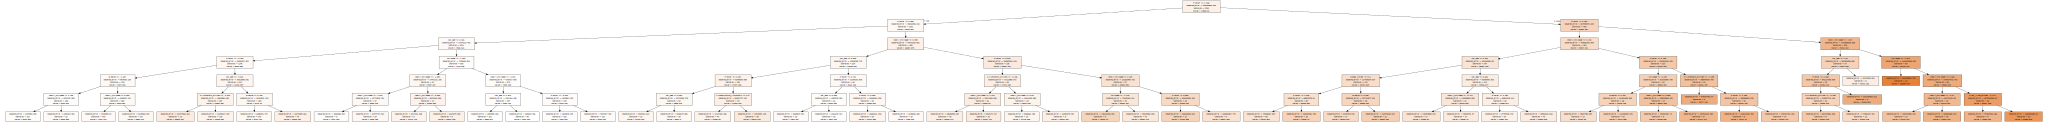

In [169]:
export_graphviz(rf_final.estimators_[1], out_file="rfr_final_1.dot", feature_names = v_feature_name , 
                impurity = True, filled = True)
# tree_final_1.dot 그리기
with open("rfr_final_1.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

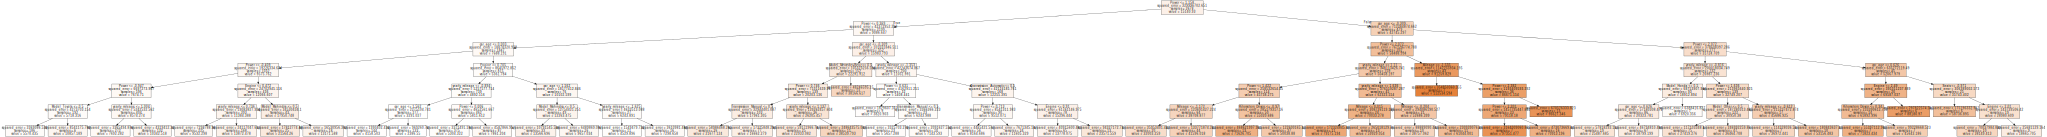

In [170]:
export_graphviz(rf_final.estimators_[10], out_file="rfr_final_10.dot", feature_names = v_feature_name, 
                impurity = True, filled = True)
# tree_final_10.dot 그리기
with open("rfr_final_10.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [171]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
3,Power,0.746
5,car_age,0.091
6,yearly_mileage,0.090
2,Engine,0.022
0,Kilometers_Driven,0.020
1,Mileage,0.012
23,Model_Mercedes-Benz,0.004
24,Model_Other,0.003
11,Transmission_Automatic,0.002
12,Transmission_Manual,0.002


Text(0, 0.5, '변수')

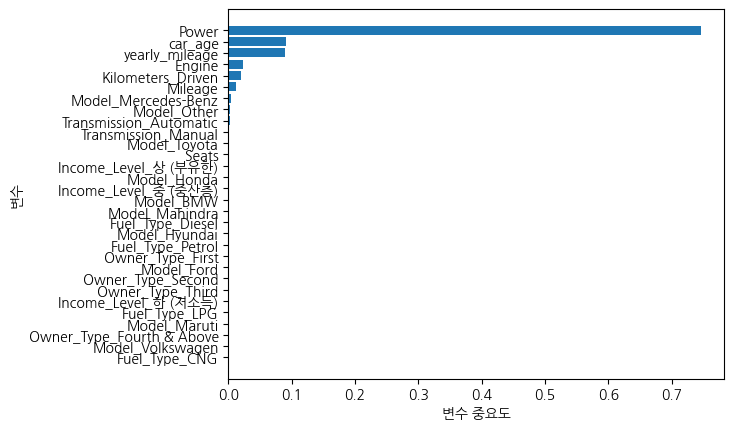

In [172]:
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

# 그래디언트부스팅

In [85]:
df_scaled_y = df_scaled["Price"]
df_scaled_x = df_scaled.drop("Price", axis = 1, inplace = False)
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_scaled_x, df_scaled_y, test_size = 0.3, random_state = 1234) 

In [86]:
# 모델 생성: GradientBoostingRegressor
gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_uncustomized.score (df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_uncustomized.score (df_test_x, df_test_y)))

Score on training set: 0.907
Score on test set: 0.855


In [87]:
gb_uncustomized.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 1234,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [88]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# n_estimatos: 트리 수 변경(10~100)
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(random_state = 1234, n_estimators = v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_n = pd.DataFrame()
df_score_n["Estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

df_score_n.round(3)

,Estimators,TrainScore,TestScore
0,10,0.686,0.680
1,20,0.812,0.795
2,30,0.849,0.820
3,40,0.867,0.834
4,50,0.878,0.838
5,60,0.887,0.846
6,70,0.893,0.849
7,80,0.897,0.851
8,90,0.902,0.853
9,100,0.907,0.855


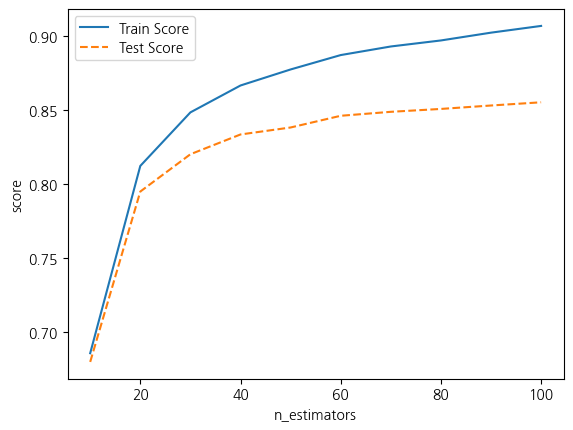

In [89]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

In [91]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수 
para_leaf = [n_leaf for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators = 60,
                                   min_samples_leaf = v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.887,0.846
1,2,0.883,0.854
2,3,0.883,0.853
3,4,0.880,0.852
4,5,0.882,0.856
5,6,0.878,0.857
6,7,0.878,0.855
7,8,0.878,0.853
8,9,0.877,0.853
9,10,0.877,0.853


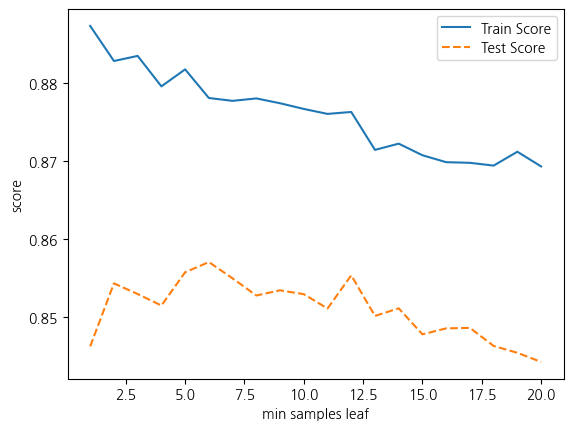

In [92]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

In [93]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_split: 분할하기 위한 노드의 최소 자료 수 
para_split = [n_split * 2 for n_split in range(1, 21)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators = 60, min_samples_leaf = 12,
                                   min_samples_split = v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.876,0.855
1,4,0.876,0.855
2,6,0.876,0.855
3,8,0.876,0.855
4,10,0.876,0.855
5,12,0.876,0.855
6,14,0.876,0.855
7,16,0.876,0.855
8,18,0.876,0.855
9,20,0.876,0.855


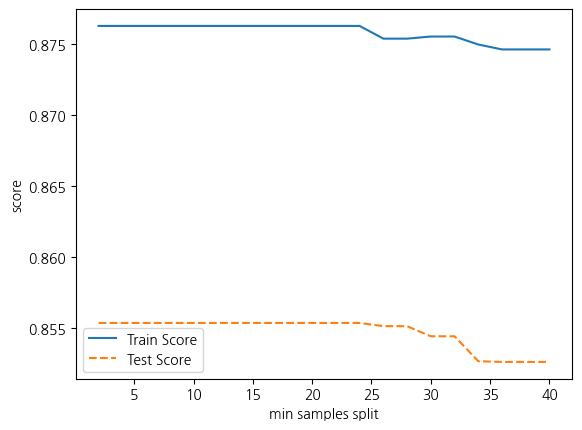

In [94]:
# 모델 설명력 그래프 확인 : 22개
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

In [95]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators = 60, min_samples_leaf = 12,
                                   min_samples_split = 10, max_depth = v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.724,0.718
1,2,0.839,0.825
2,3,0.876,0.855
3,4,0.906,0.870
4,5,0.917,0.870
5,6,0.927,0.874
6,7,0.938,0.873
7,8,0.945,0.872
8,9,0.950,0.875
9,10,0.953,0.872


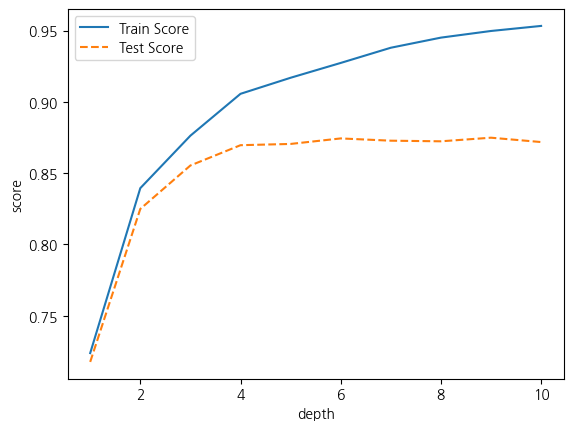

In [97]:
# 모델 설명력 그래프 확인 : 4개
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("depth")
plt.legend()

In [98]:
# learning_rate: 학습률 변경에 따른 모델 성능
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# learning rate: 학습률 변경 0.1 ~ 0.9
para_lr = [lr * 0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators = 60, min_samples_leaf = 12,
                                   min_samples_split = 10, max_depth = 5, learning_rate = v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_lr = pd.DataFrame()
df_score_lr["LearningRate"] = para_lr
df_score_lr["TrainScore"] = train_score
df_score_lr["TestScore"] = test_score

df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.917,0.870
1,0.2,0.939,0.876
2,0.3,0.949,0.870
3,0.4,0.957,0.876
4,0.5,0.964,0.860
5,0.6,0.968,0.854
6,0.7,0.971,0.832
7,0.8,0.971,0.809
8,0.9,0.975,0.813


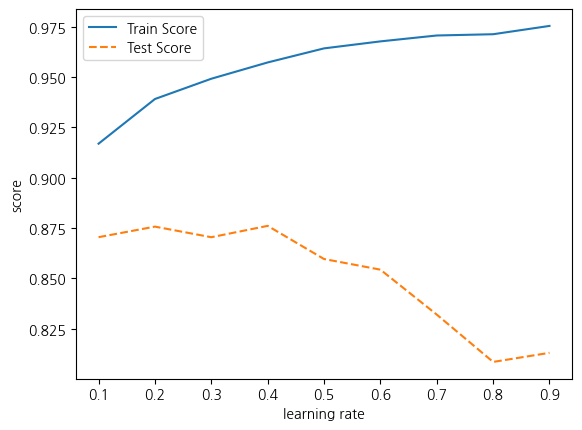

In [99]:
# 모델 설명력 그래프 확인
plt.plot(para_lr, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_lr, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("learning rate")
plt.legend()

In [100]:
# 최종모델 선택
gb_final = GradientBoostingRegressor(random_state=1234, n_estimators = 60, min_samples_leaf = 12,
                                     min_samples_split = 10, max_depth = 5, learning_rate = 0.2)
gb_final.fit(df_train_x, df_train_y)
print("Score on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set: 0.939
Score on test set: 0.876


In [101]:
test_pred =gb_final.predict(df_test_x)
print('test data의 실제값 : \n', df_test_y[:10])
print('test data의 예측값 : \n', test_pred[:10])

test data의 실제값 : 
 3838     5196.73
1391    12646.92
4458    19545.24
1281     6898.32
1386    38324.00
2302    15881.47
3879     8277.98
2622     7649.47
1524    19315.30
330      4292.29
Name: Price, dtype: float64
test data의 예측값 : 
 [ 4327.46500604 10277.53812263 19189.38538398  5980.69781904
 41319.70366168 17945.56434589  8457.58367035  6309.36253523
 18337.76521588  6272.45450089]


In [102]:
# feature_importances_: 설명변수의 중요도
v_feature_name = df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
3,Power,0.695
5,car_age,0.101
6,yearly_mileage,0.069
2,Engine,0.041
0,Kilometers_Driven,0.034
1,Mileage,0.022
11,Transmission_Automatic,0.006
24,Model_Other,0.006
23,Model_Mercedes-Benz,0.006
8,Fuel_Type_Diesel,0.003


Text(0, 0.5, '변수')

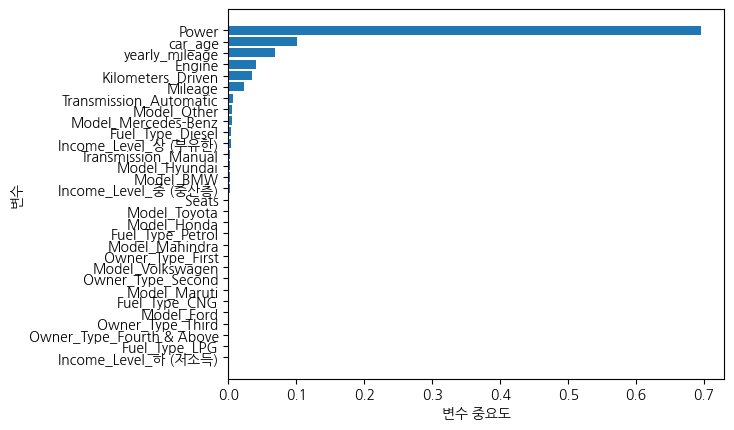

In [103]:
# 중요도가 높은 변수를 상위에 그림. 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")